In [23]:
import pandas as pd
import sweetviz as sv
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.feature_selection import f_classif
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import mutual_info_classif
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report
# инструмент для создания и обучения модели
from sklearn.linear_model import LogisticRegression
from sklearn import metrics  # инструменты для оценки точности модели
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, f1_score, accuracy_score, roc_curve, roc_auc_score
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import cross_validate

data = pd.read_csv('train.csv')

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73799 entries, 0 to 73798
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   client_id         73799 non-null  int64  
 1   app_date          73799 non-null  object 
 2   education         73492 non-null  object 
 3   sex               73799 non-null  object 
 4   age               73799 non-null  int64  
 5   car               73799 non-null  object 
 6   car_type          73799 non-null  object 
 7   decline_app_cnt   73799 non-null  int64  
 8   good_work         73799 non-null  int64  
 9   score_bki         73799 non-null  float64
 10  bki_request_cnt   73799 non-null  int64  
 11  region_rating     73799 non-null  int64  
 12  home_address      73799 non-null  int64  
 13  work_address      73799 non-null  int64  
 14  income            73799 non-null  int64  
 15  sna               73799 non-null  int64  
 16  first_time        73799 non-null  int64 

<a id='0'></a> 
# Оглавление

<a href='#1'>1. Первичный осмотр данных<br>
<a href='#2'>2. Классы для анализа и моделирования<br>
<a href='#21'>&nbsp;&nbsp;2.1 Класс EDA для разведывательного анализа<br>
<a href='#22'>&nbsp;&nbsp;2.2 Класс Modeler для разбиения данных и моделирования<br>
<a href='#3'>3. Обработка и анализ числовых признаков<br>
<a href='#4'>4. Обработка и анализ категориальных признаков<br>
<a href='#5'>5. Деление данных на обучающую и тестовую части<br>
<a href='#6'>6. Моделирование<br>
<a href='#61'>&nbsp;&nbsp;6.1 Первая модель<br>
<a href='#62'>&nbsp;&nbsp;6.2 Улучшение модели<br>
<a href='#63'>&nbsp;&nbsp;6.3 Пробуем undersampling и oversampling<br>
<a href='#64'>&nbsp;&nbsp;6.4 Кросс-валидация модели<br>
<a href='#7'>7. Подбор гиперпараметров<br>
<a href='#71'>&nbsp;&nbsp;7.1 Поиск параметров<br>
<a href='#72'>&nbsp;&nbsp;7.2 Моделирование с рекомендованными параметрами<br>
<a href='#8'>8. Генерирование файла для kaggle

<a id='1'></a> 
# 1. Первичный осмотр данных

                                             |          | [  0%]   00:00 -> (? left)


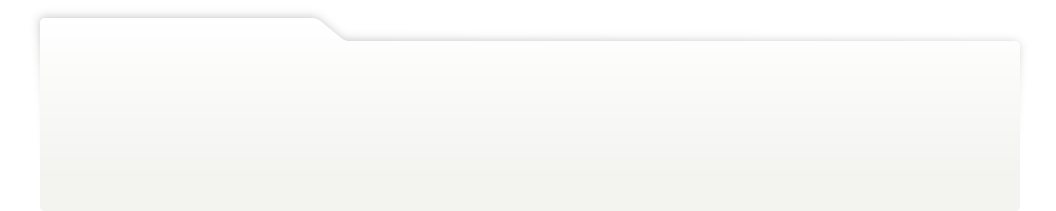
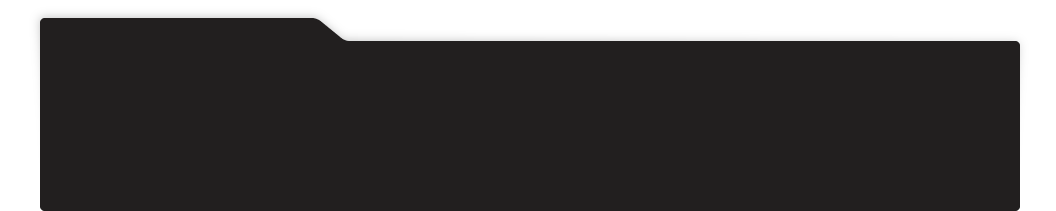
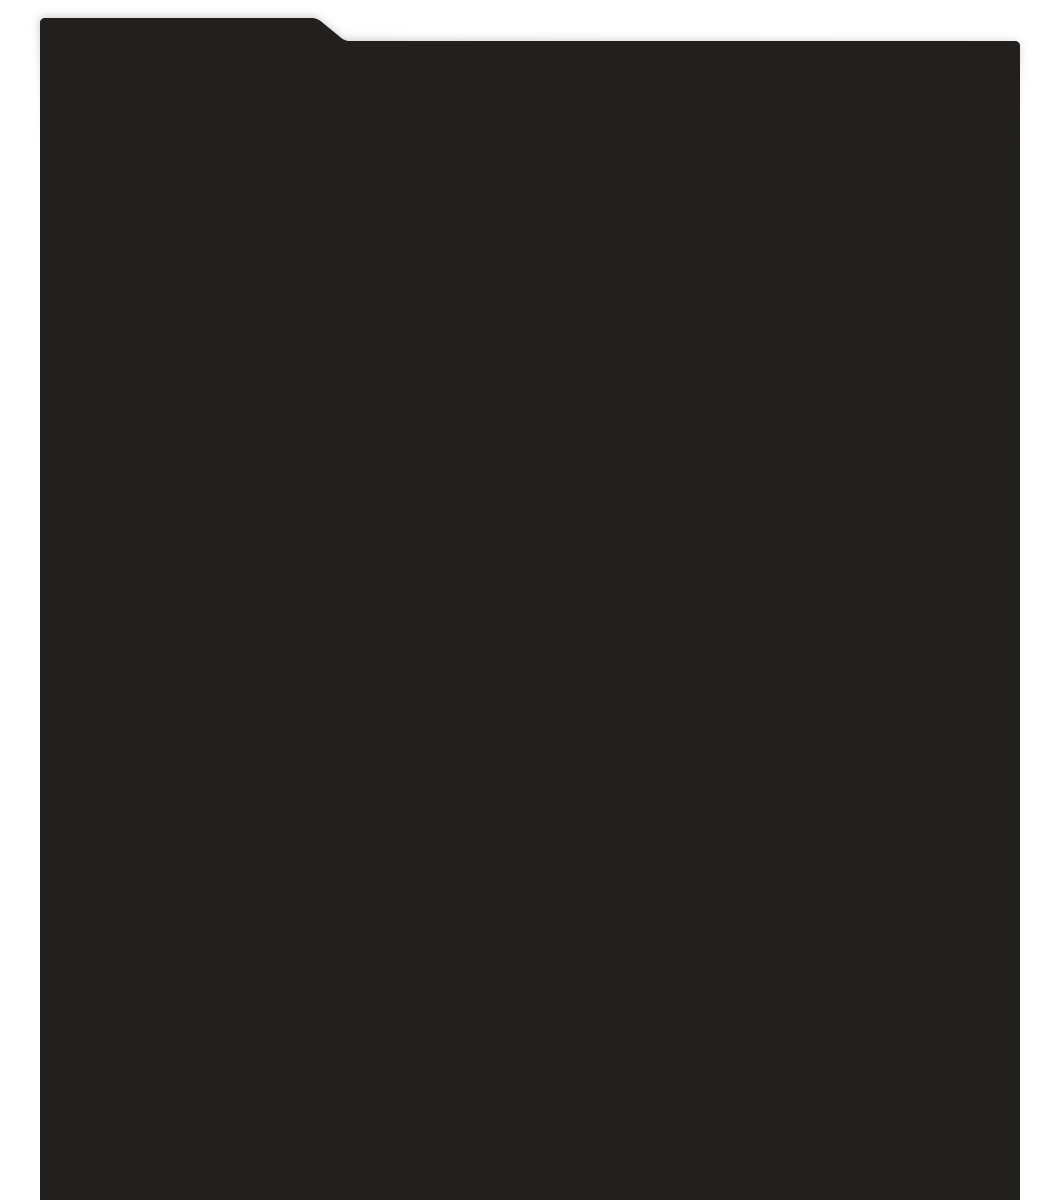
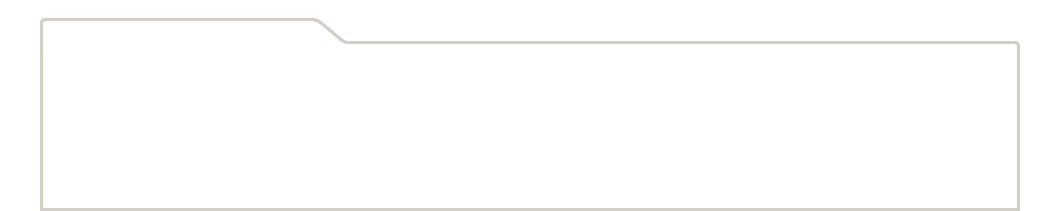
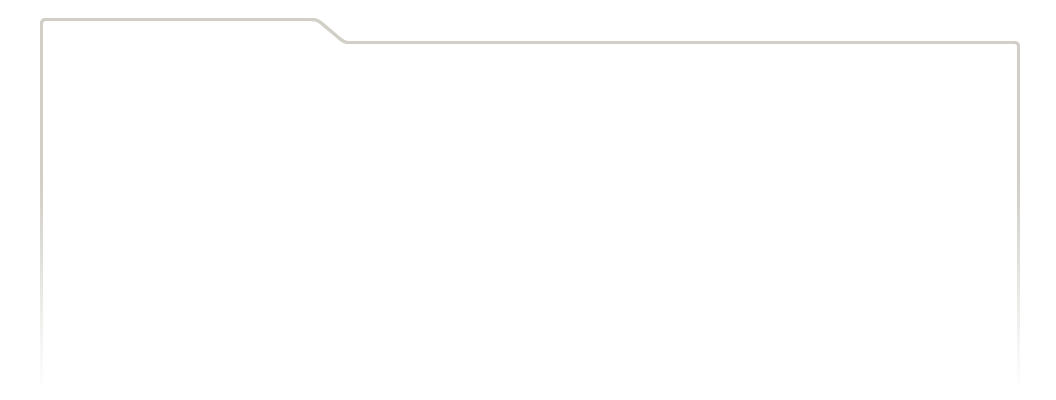
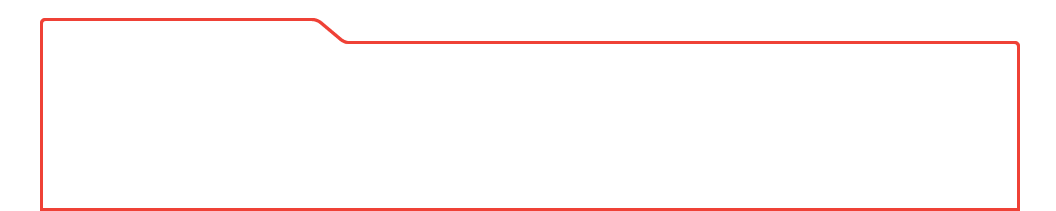
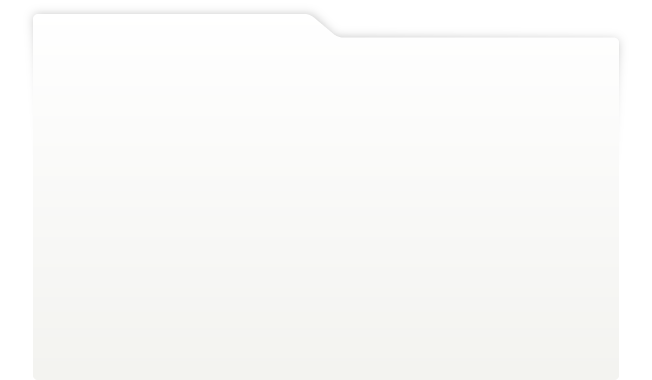
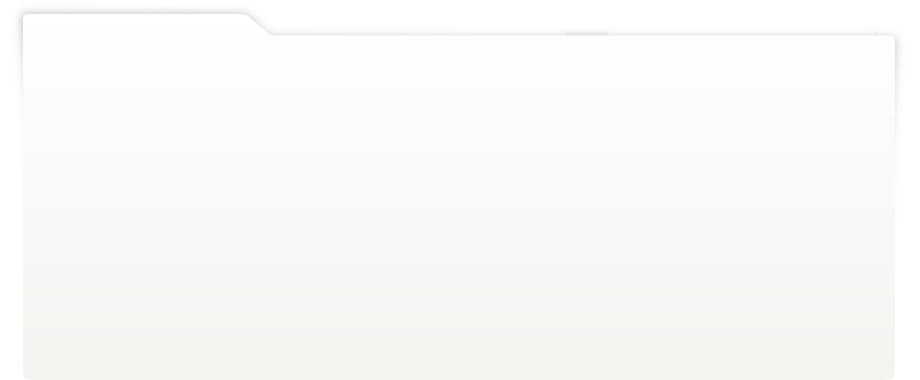
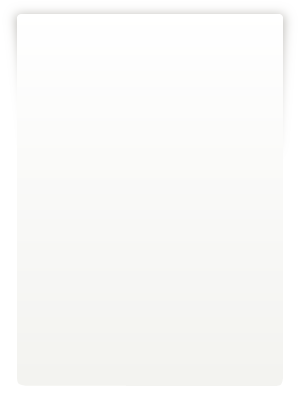
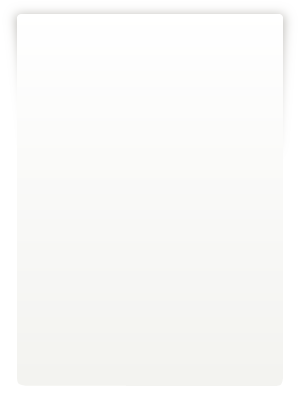
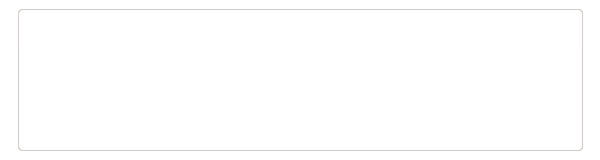
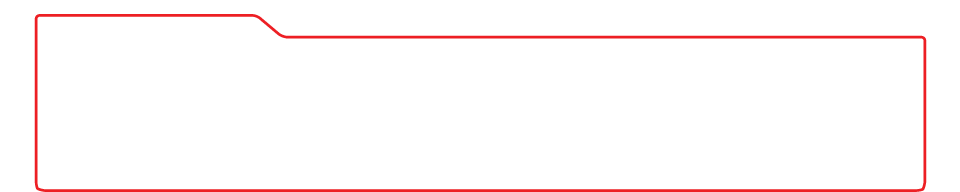
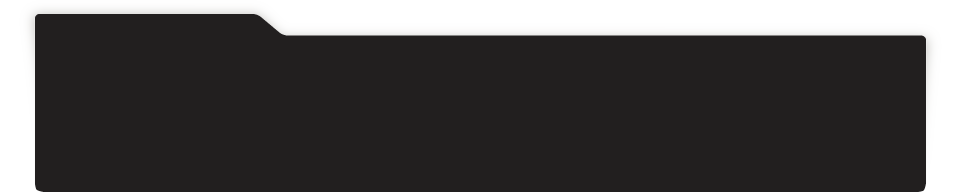
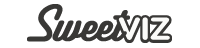
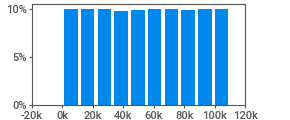
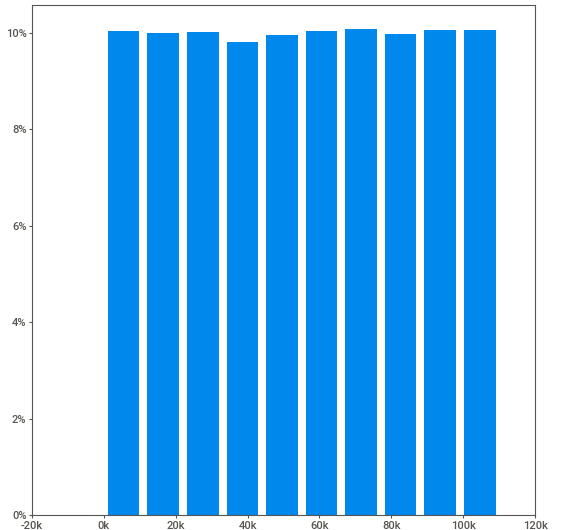
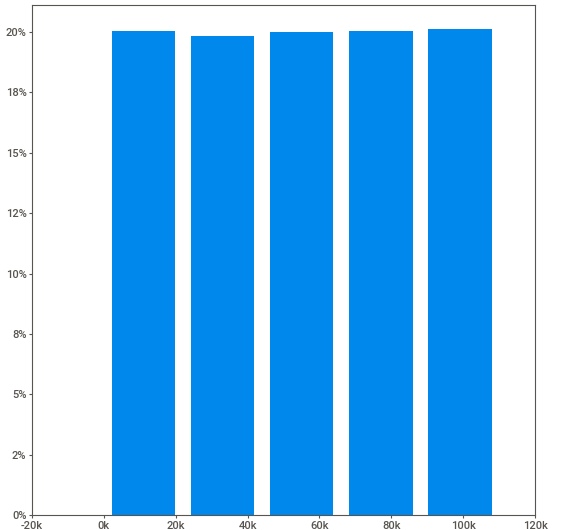
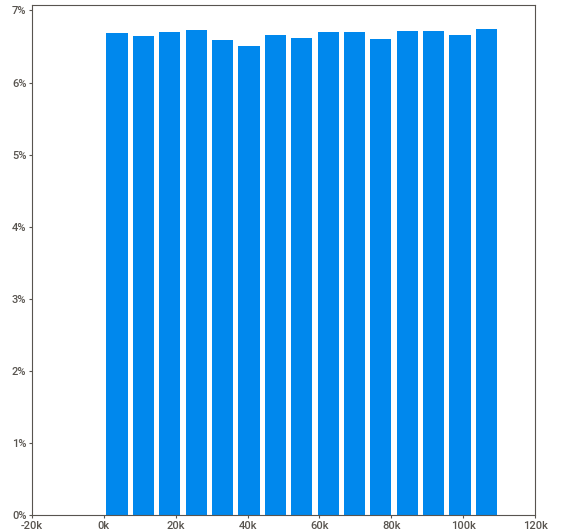
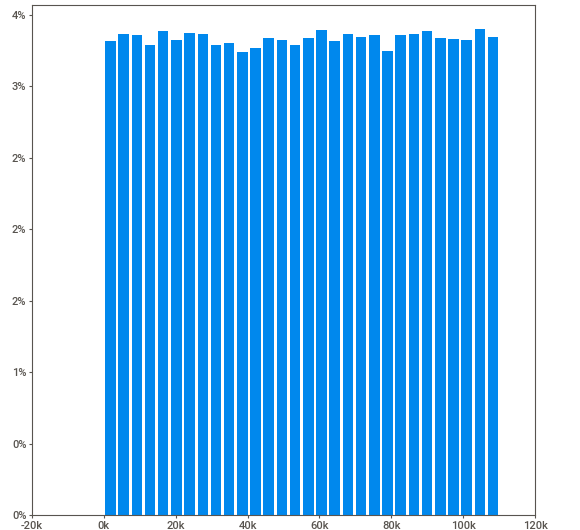
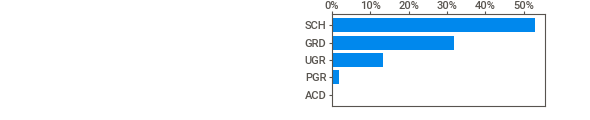
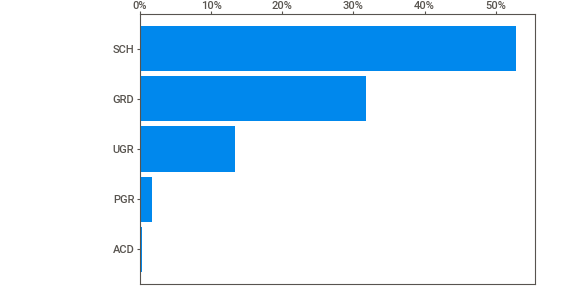
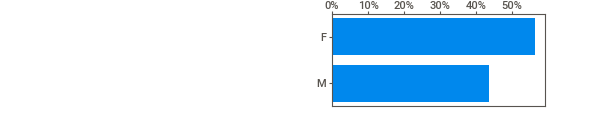
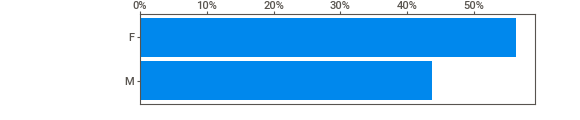
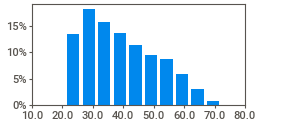
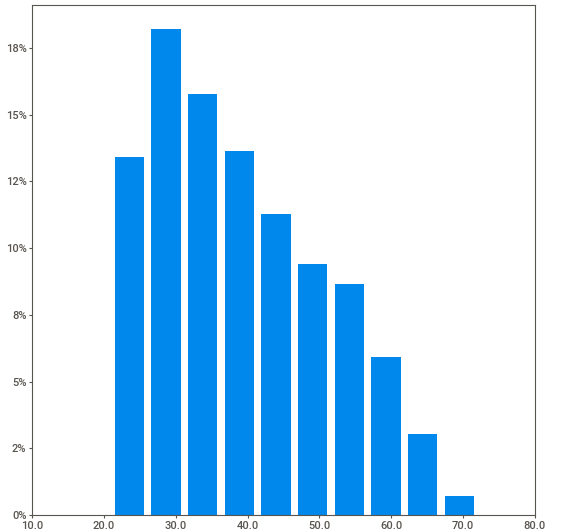
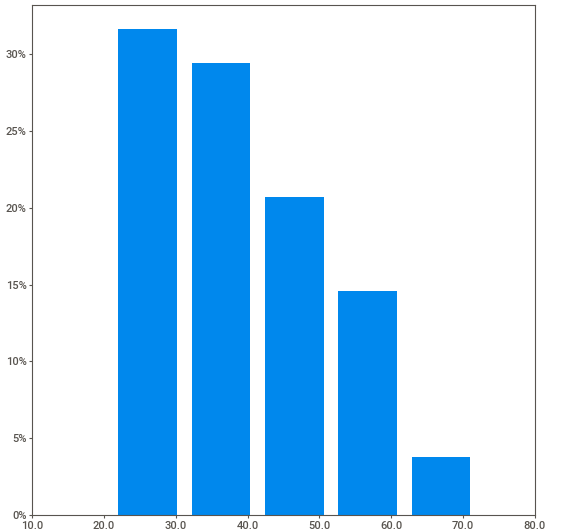
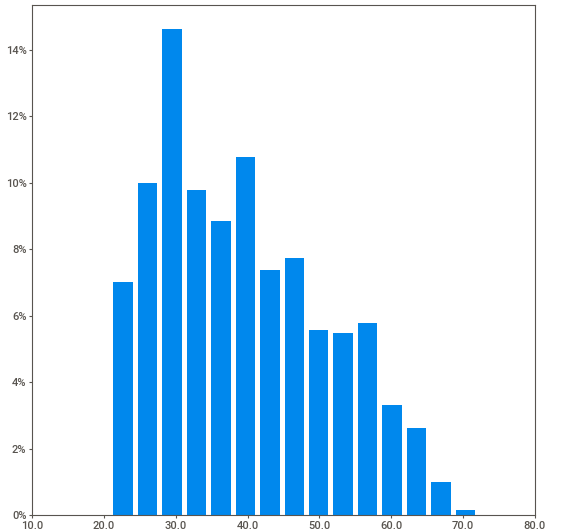
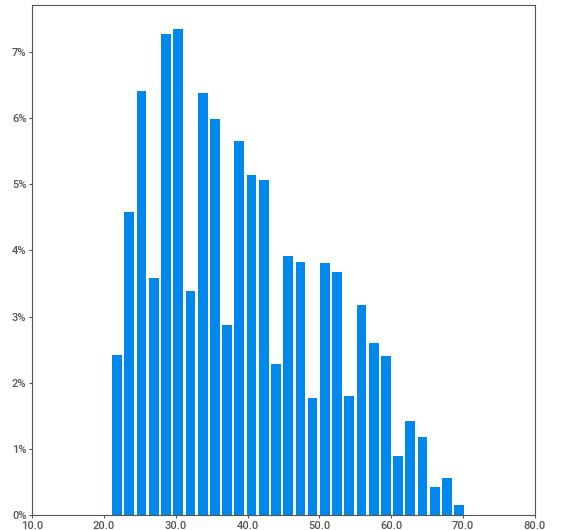
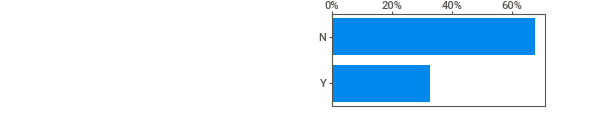
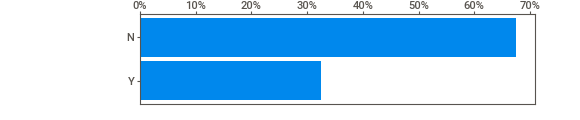
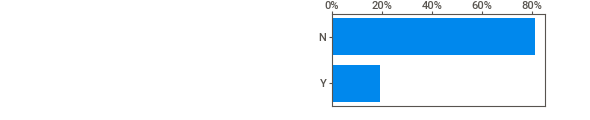
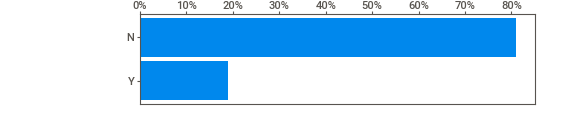
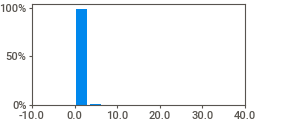
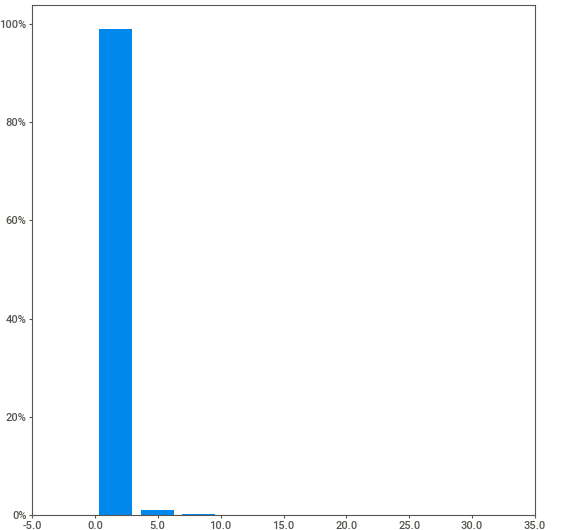
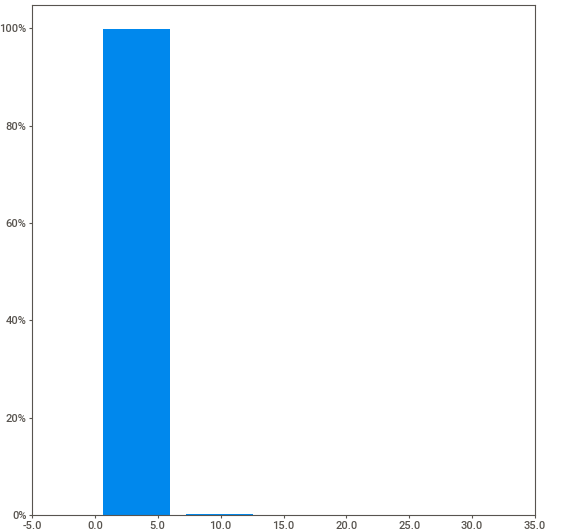
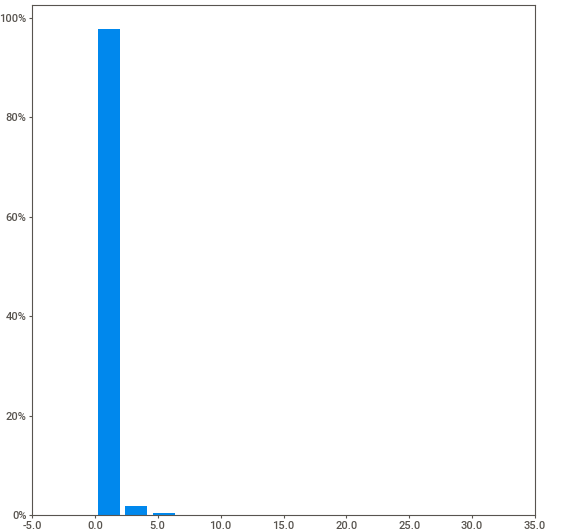
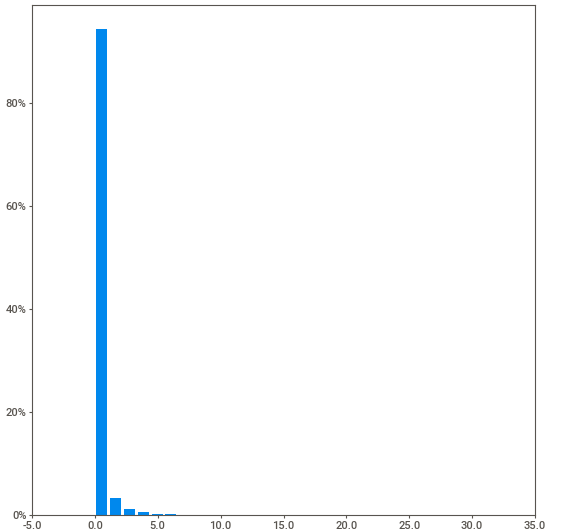
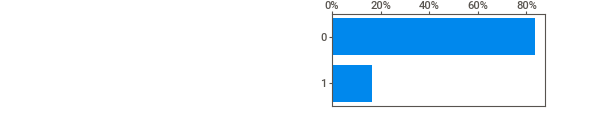
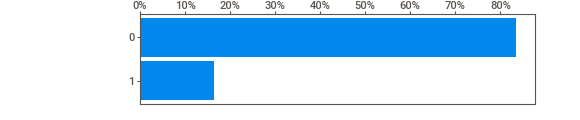
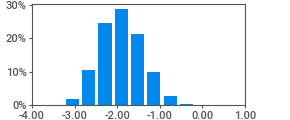
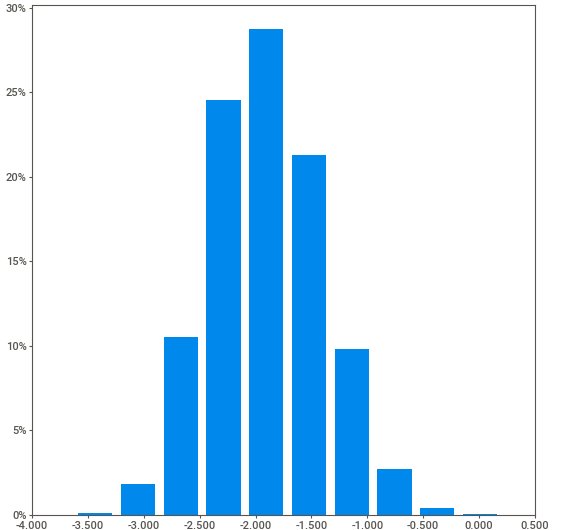
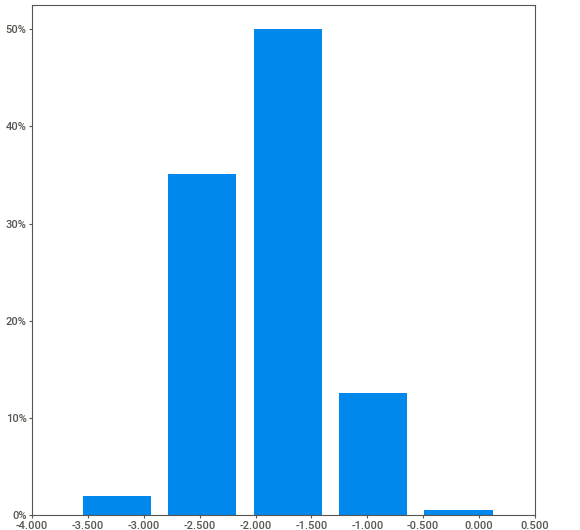
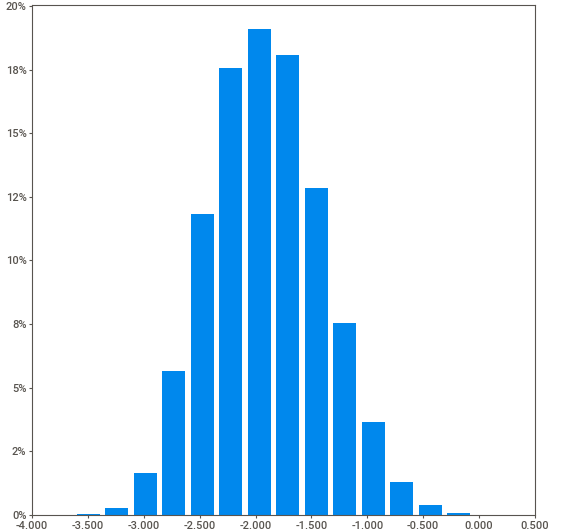
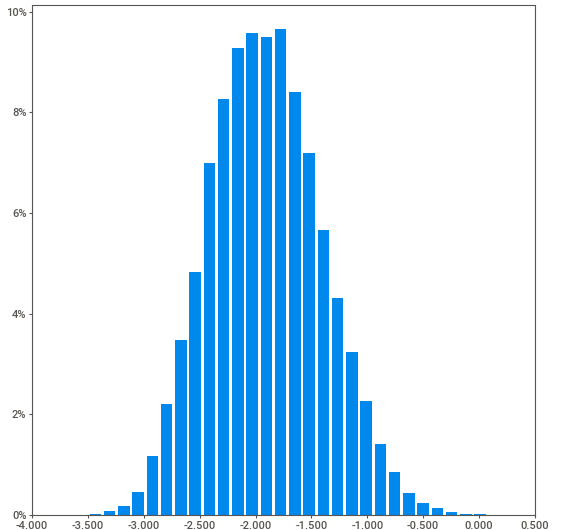
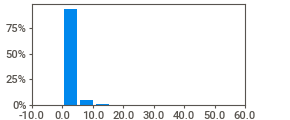
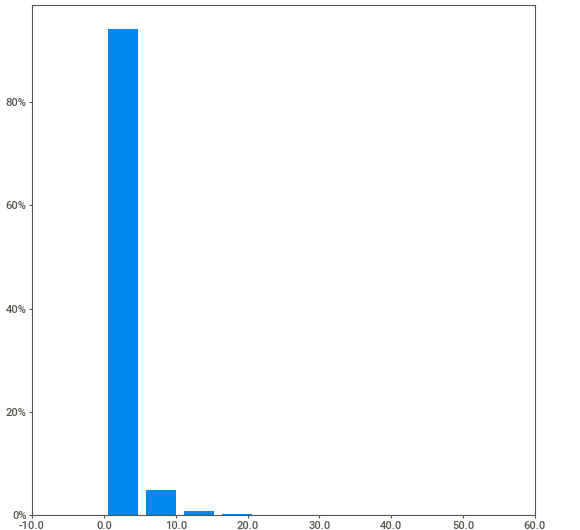
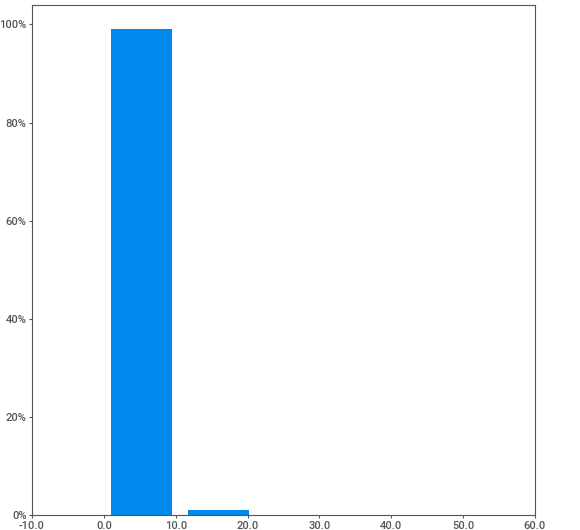
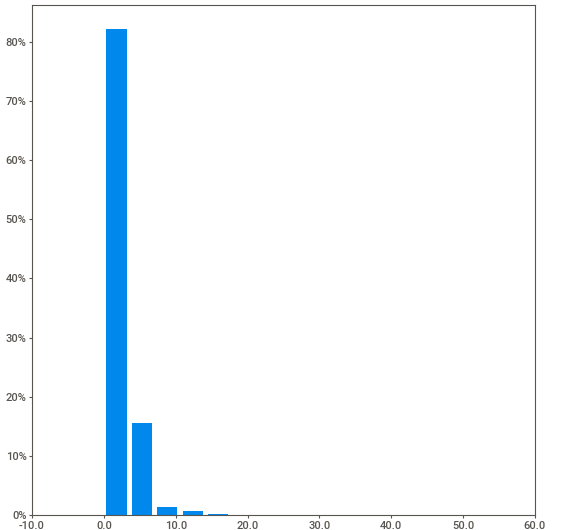
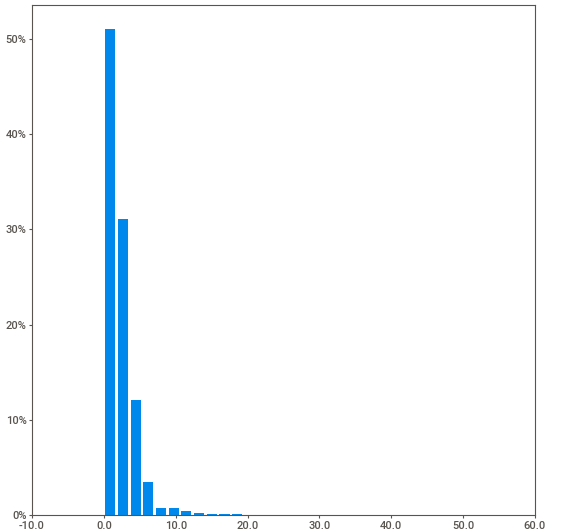
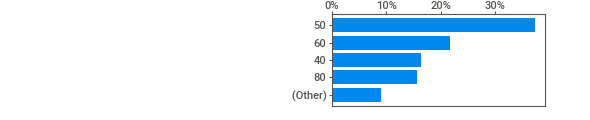
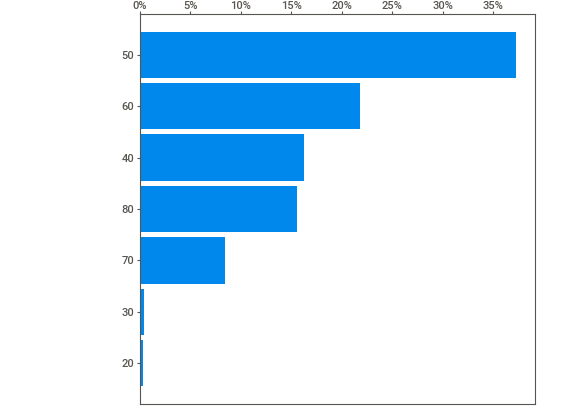
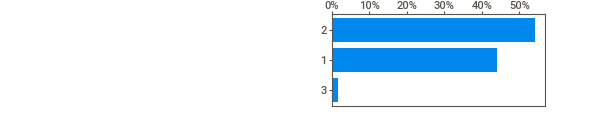
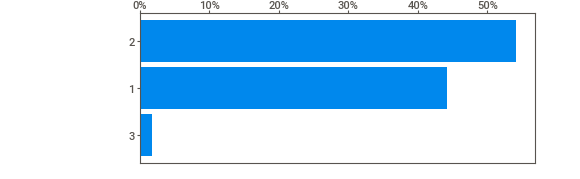
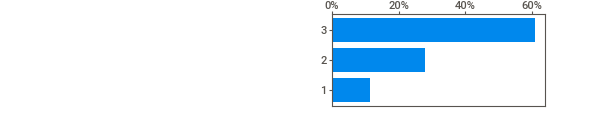
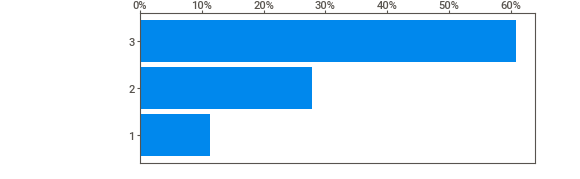
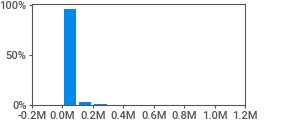
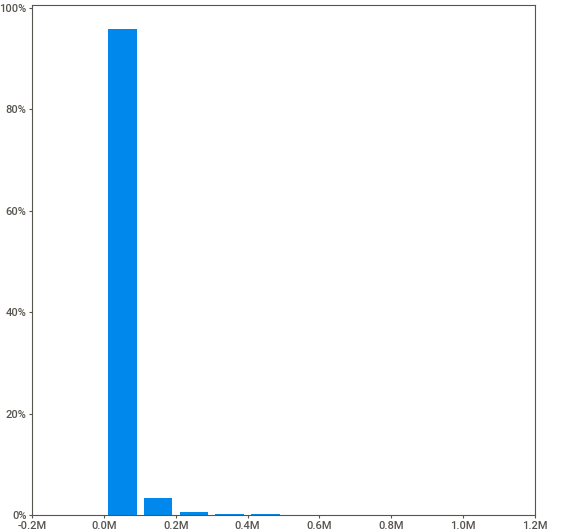
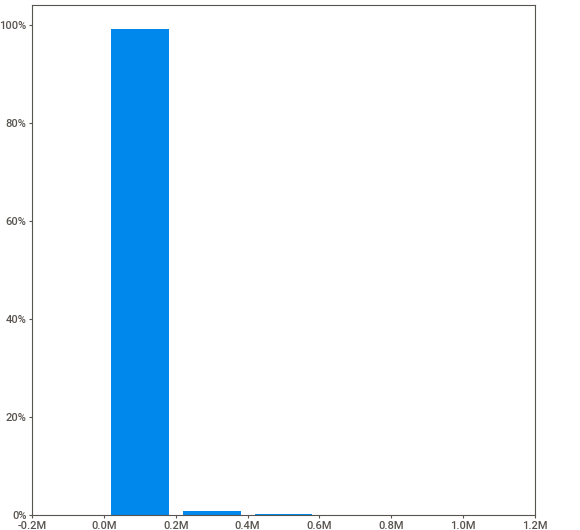
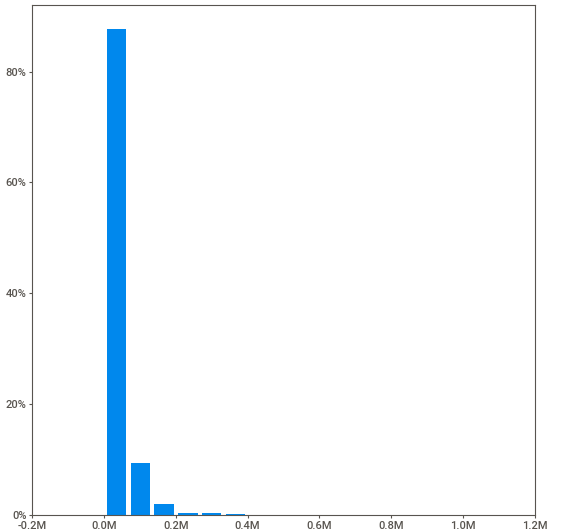
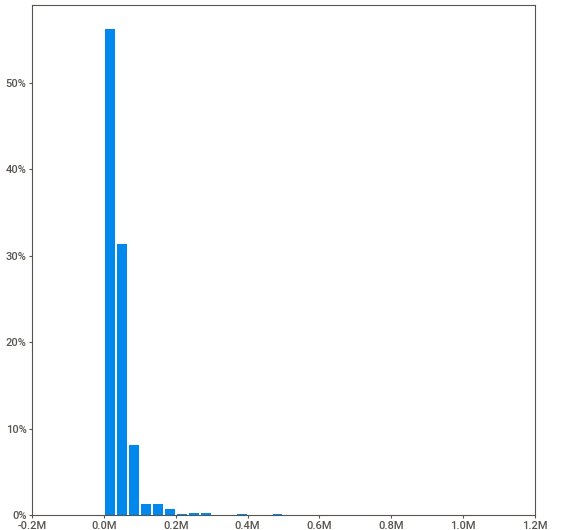
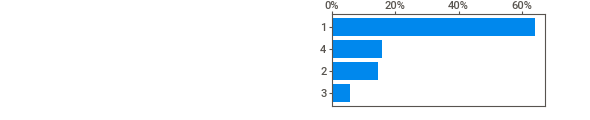
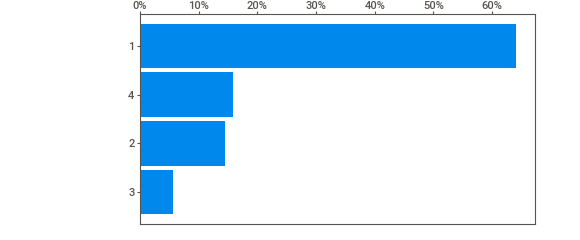
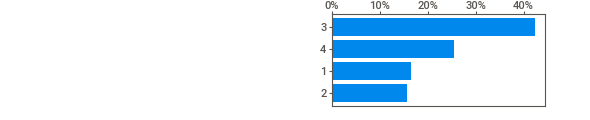
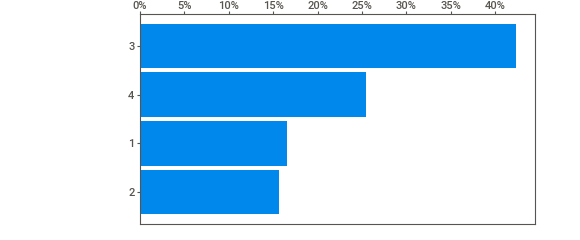
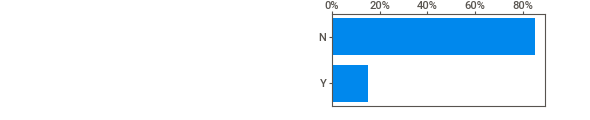
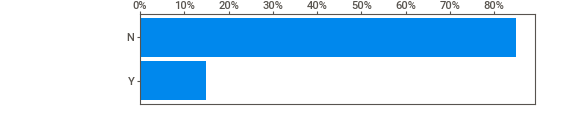
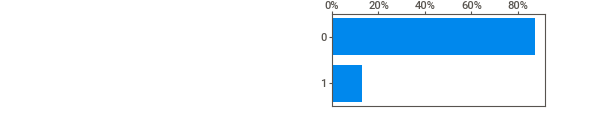
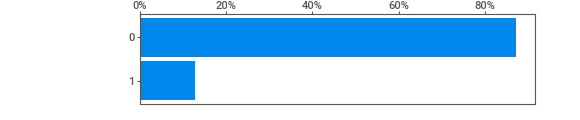
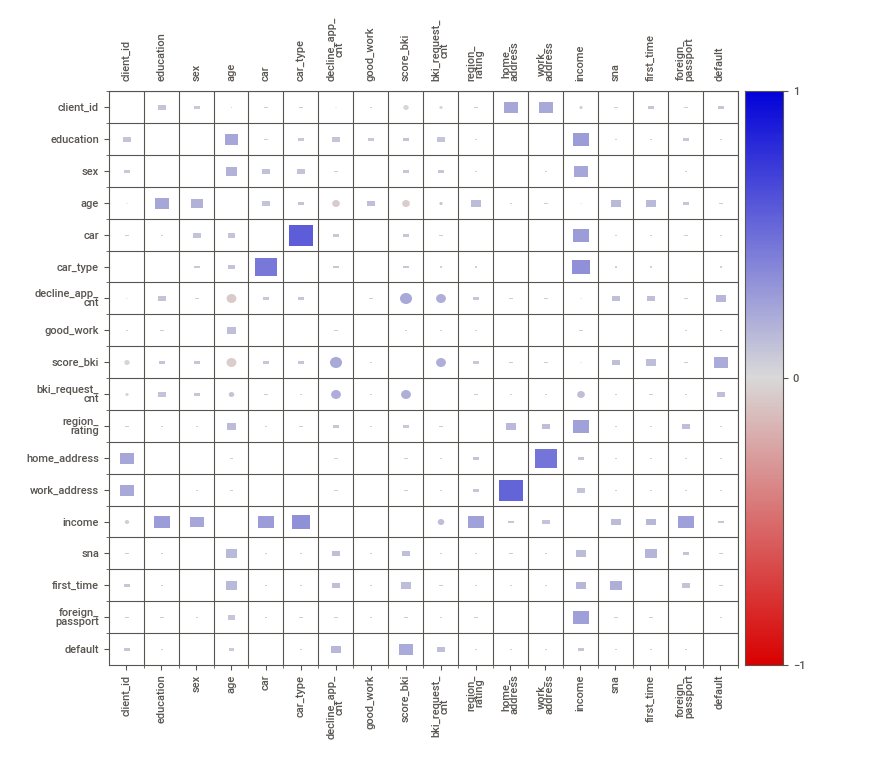
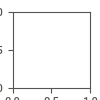

In [24]:
# генерируем отчёт о датачате при помощи sweetviz
data_report = sv.analyze(data)
data_report.show_notebook()

## Анализ данных по отчёту

Данные практически присутствуют во всех полях, кроме поля _education_, в котором есть пропуски (менее 1 процента). Пропуски будут заполнены самым частым значением.<br>
**client_id** - уникальный идентификатор клиента. Поле безполезное из-за его уникальности для каждого клиента, поэтому будет опущено за ненадобностью.<br>
**app_date** - дата подачи заявки. Поле тоже безполезное, т.к. дата подачи заявки не влияет на рейтинг клиента.<br>
**education** - поле со значением образования клиента. В поле имеются пропуски, которые будут заполнены самым частым значением (SCH).<br>
**sex** - пол клиента. Значений всего два и распределенны примерно одинаково.<br>
**age** - возраст клиента. Распределение значений возраста имеет правый хвост, поэтому требуется логарифмирование значений поля для получения нормального распределения значений.<br>
**car** - наличие автомобиля у клиента. Значений всего два и больше всего значений N и это говорит о том, что больше всего клиентов без автомобиля.<br>
**car_type** - наличие у клиента иномарки. Распределение по значением говорит, что у клиентов ещё меньше иномарок, чем автомобилей вообще.<br>
**decline_app_cnt** - количество отказанных заявок. Большая часть значений находится около нуля. Чем больше значение этого поля, тем меньше вероятность, что клиент получит кредит.<br>
**good_work** - наличие "хорошей" работы. Признак имеет два значения и больше всего значений "Нет".<br>
**score_bki** - бал клиента в системе БКИ. Значения распределенны примерно нормально.<br>
**bki_request_cnt** - количество запросов в систему БКИ. Значения распределенны в большинстве своём возле ноля.<br>
**region_rating** - рейтинг региона. Значения распределенны с хвостом с права.<br>
**home_address** - категоризатор домашнего адреса. Данные распределенны с правым хвостом.<br>
**work_address** - категоризатор рабочего адреса. Данные распределенны с правым хвостом.<br>
**income** - доход заемщика. Данные распределенны около 0 и длинным низким хвостом.<br>
**sna** - связь заемщика с клиентами банка. Данные распределенны неупорядоченно.<br>
**first_time** - давность наличия информации о заемщике. Данные распределенны неупорядоченно.<br>
**foreign_passport** - наличие загранпаспорта. Признак имеет два значения и больше всего значений об отсутствии загранпасспорта у клиентов.<br>
**default** - флаг дефолта по кредиту. Целевой признак, который надо предсказать. Больше всего значений "нет".

#### <a href='#0'>К Оглавлению

<a id='2'></a> 
# 2. Классы для анализа и моделирования

<a id='21'></a> 
## 2.1 Класс EDA для разведывательного анализа

In [25]:
class EDA:
    """
    Класс для разведывательного анализа   
    """

    __loc_df = None

    # разделяем столбцы на категории
    __num_cols = ['age', 'score_bki', 'decline_app_cnt',
                  'bki_request_cnt', 'income']  # числовые
    # категориальные. Признак 'education' не добавляем т.к. значения признака будут трансформированны в новые признаки
    __cat_cols = ['first_time', 'sna', 'work_address',
                  'home_address', 'region_rating']
    __bin_cols = ['sex', 'car', 'car_type',
                  'good_work', 'foreign_passport']  # бинарные

    def __init__(self, df):
        self.__loc_df = df.copy()  # запоминеем датасет
        # удаляем ненужные поля
        self.__loc_df.drop(['client_id', 'app_date', ], axis=1, inplace=True)

    def get_dataframe(self):
        """возвращает датачет"""
        return self.__loc_df

    def get_numeric_columns(self):
        """возвращает список названий цифровых столбцов"""
        return self.__num_cols

    def make_boxplots_default(self):
        """отображаем боксплоты для дефолтных и не дефолтных клиентов"""
        if self.__loc_df is None:
            print("Датафрейм не задан! Укажите датафрейм и пробуйте снова")
            return

        # отображаем боксплоты числовых признаков для дефолтных и не дефолтных клиентов
        for column in self.__loc_df.columns:
            if self.__loc_df[column].dtype.name != 'object' and column in ['age', 'income', 'decline_app_cnt', 'bki_request_cnt']:
                # show boxplot
                self.get_boxplot(self.__loc_df, 'default', column, 3, 6)

    def get_correlations(self):
        """возвращаем корреляции цифровых признаков"""
        sns.heatmap(self.__loc_df[self.__num_cols].corr().abs(), vmin=0,
                    vmax=1, annot=True, cmap='YlOrBr')

    def get_fields_priority(self):
        """отображаем график значимости цифровых признаков относительно целевой переменной"""
        imp_num = pd.Series(f_classif(self.__loc_df[self.__num_cols], self.__loc_df['default'])[
            0], index=self.__num_cols)
        imp_num.sort_values(inplace=True)
        imp_num.plot(kind='barh')

    def get_default_customers_percent(self, field_name, value_index):
        """возвращаем процент клиентов от дефолтных клиентов по заданному полю"""
        return data[self.__loc_df['default'] == 1][field_name].value_counts(normalize=True)[value_index] * 100

    def get_column_dummies(self, column_name):
        """превращаем значения поля в признаки"""
        # Заполним эти пропуски самым частым значением 'SCH'
        self.__loc_df[column_name].fillna(
            self.__loc_df[column_name].mode()[0], inplace=True)

        # создаём новые признаки из значений
        self.__loc_df = pd.get_dummies(self.__loc_df, columns=[
                                       column_name], dummy_na=True)

        # добавляем полученные признаки к категориальным признакам
        for column in self.__loc_df.columns:
            if column_name in column and not 'nan' in column:
                self.__cat_cols.append(column)

    def view_bin_columns(self):
        """отображаем бинарные признаки"""
        for column in self.__loc_df[self.__bin_cols]:
            print(self.__loc_df[column].value_counts(),  '\n'*2)

    def encode_bin_columns(self):
        """перекодируем бинарные признаки"""
        label_encoder = LabelEncoder()

        for column in self.__bin_cols:
            self.__loc_df[column] = label_encoder.fit_transform(
                self.__loc_df[column])
            print(column, dict(enumerate(label_encoder.classes_)))

        # убедимся в преобразовании
        self.__loc_df.sample()

    def view_cat_columns(self):
        """отображаем категориальные признаки"""
        self.__loc_df[['first_time', 'sna', 'work_address',
                       'home_address', 'region_rating']].hist(figsize=(8, 8))

    def view_cat_columns_priority(self):
        """отображаем график значимости категориальных признаков"""
        imp_cat = pd.Series(mutual_info_classif(
            self.__loc_df[self.__bin_cols +
                          self.__cat_cols], self.__loc_df['default'],
            discrete_features=True), index=self.__bin_cols + self.__cat_cols)
        imp_cat.sort_values(inplace=True)
        imp_cat.plot(kind='barh')

    def view_cat_cols_corr(self):
        """отображаем корреляции между категориальными признаками"""
        plt.figure(figsize=(12, 9))
        sns.heatmap(self.__loc_df[['first_time', 'sna', 'work_address', 'home_address', 'region_rating'] +
                                  self.__bin_cols].corr(), vmin=0, vmax=1, annot=True, cmap='YlOrBr', linewidths=.5)

    def view_cols_change_with_score_bki(self):
        """отображение боксплотов для признаков меняющихся вместе с score_bki"""        
        for column in self.__num_cols+self.__cat_cols+self.__bin_cols:
            eda.get_boxplot(self.__loc_df.loc[self.__loc_df.loc[:, column].isin(
                self.__loc_df.loc[:, column].value_counts(normalize=True).index[:10])], column, 'score_bki', 10, 5)

    def get_boxplot(self, df, x_column, y_column, fig_size_x, fig_size_y):
        '''Функция для построения boxplot'''
        fig, ax = plt.subplots(figsize=(fig_size_x, fig_size_y))
        sns.boxplot(x=x_column, y=y_column,
                    data=df,
                    ax=ax)
        plt.xticks(rotation=45)
        ax.set_title('Boxplot for ' + x_column + ' -> ' + y_column)
        plt.show()

#### <a href='#0'>К Оглавлению

<a id='22'></a> 
## 2.2 Класс Modeler для разбиения данных и моделирования

In [26]:
class Modeler:
    """
    Класс для моделирования
    """

    __loc_df = None  # локальная копия датафрейма
    __loc_with_poly_ft = False  # метка "добавить полиноминальные свойства"
    __num_cols = []  # числовые признаки
    __drop_columns = []  # признаки для удаления
    __random_state = None  # значение random_state
    __test_size = 0.2  # размер тестовой части

    # мак итераций для логистической регрессии (парамерт инициализации)
    __max_iter = 100
    # штраф для логистической регрессии (парамерт инициализации)
    __penalty = 'l2'
    # значение class_weight для логистической регрессии (парамерт инициализации)
    __class_weight = None
    # значение tol для логистической регрессии (парамерт инициализации)
    __tol = 1e-4
    # значение solver для логистической регрессии (парамерт инициализации)
    __solver = 'liblinear'

    # обучающая и тестовая выборки
    __X_train = None
    __X_test = None
    __y_train = None
    __y_test = None

    __verbose = False  # отладочный режим для отслеживания выполнения
    __logreg = None  # объект логистической регрессии

    def __init__(self, df, num_cols, with_poly_ft=False, drop_columns=[], random_state=42,
                 random_seed=42, test_size=0.2, verbose_mode=False, max_iter=100, penalty='l2',
                 class_weight=None, tol=1e-4, solver='liblinear'):

        self.__loc_df = df.copy()
        self.__loc_with_poly_ft = with_poly_ft
        self.__num_cols = num_cols
        self.__drop_columns = drop_columns
        self.__random_state = random_state
        self.__random_seed = random_seed
        self.__test_size = test_size
        self.__verbose = verbose_mode

        self.__max_iter = max_iter
        self.__penalty = penalty
        self.__class_weight = class_weight
        self.__tol = tol
        self.__solver = solver

    def get_logreg(self):
        """возвращает объект логистической регрессии"""
        return self.__logreg

    def prepare_data(self):
        """подготовка данных: логарифмирование числовых признаков и нормализация данных"""

        if self.__verbose:
            print("Логарифмируем Age, decline_app_cnt, income и bki_request_cnt")

        # логарифмируем признак age
        self.__loc_df['age'] = np.log(self.__loc_df['age'] + 1)

        # логарифмируем признак decline_app_cnt
        self.__loc_df['decline_app_cnt'] = np.log(
            self.__loc_df['decline_app_cnt'] + 1)

        # логарифмируем признак income
        self.__loc_df['income'] = np.log(self.__loc_df['income'] + 1)

        # логарифмируем признак bki_request_cnt
        self.__loc_df['bki_request_cnt'] = np.log(
            self.__loc_df.bki_request_cnt + 1)

        if self.__verbose:
            print("Добавлять или не добавлять полиноминальные признаки")

        # add polynomial features to dataframe
        if self.__loc_with_poly_ft:
            poly_features = self.__init_poly_ft()

            self.__loc_df = pd.concat([self.__loc_df, poly_features], axis=1)

        if self.__verbose:
            print("Нормализация данных")

        # normalize data
        self.__normalize_data()

        if self.__verbose:
            print("Удаление ненужных столбцов: " +
                  ', '.join(self.__drop_columns))

        # drop unneccessary columns
        if len(self.__drop_columns) > 0:
            self.__loc_df.drop(columns=self.__drop_columns)

    def split_data(self):
        """Разделение датафрейма на обучающую и тестовую выборки"""
        X, y = self.__get_init_data()

        # split data
        self.__X_train, self.__X_test, self.__y_train, self.__y_test = self.__split_data(
            X, y)

        print("Разбиение завершено! Можно моделировать!")

    def make_model(self):
        """создаётся модель"""
        if self.__X_train is None:
            print("Нет обучающих данных для генерирования модели. Сгенерируйте обучающую выборку и пробуйте снова!")
            return

        # инициализация логистической регресии
        self.__logreg = LogisticRegression(
            solver=self.__solver, max_iter=self.__max_iter,  random_state=self.__random_state, penalty=self.__penalty)
        # learn model
        self.__logreg.fit(self.__X_train, self.__y_train)

        # предсказание значений
        y_pred = self.__logreg.predict(self.__X_test)

        # отображение отчёта о моделировании
        self.__show_modeling_report(
            self.__logreg, self.__X_train, self.__y_train, self.__y_test, y_pred)

    def make_model_os_us(self):
        """Генерирование модели с undersampling и oversampling"""
        X, y = self.__get_init_data()

        rus = SMOTE(sampling_strategy=1, random_state=self.__random_state)
        X_us, y_us = rus.fit_resample(X, y)

        X_train_us, X_test_us, y_train_us, y_test_us = train_test_split(
            X_us, y_us, test_size=0.10, shuffle=True, random_state=self.__random_state)

        self.__logreg = LogisticRegression(
            solver=self.__solver, max_iter=self.__max_iter, random_state=self.__random_state,
            penalty=self.__penalty)
        self.__logreg.fit(X_train_us, y_train_us)

        y_pred_us = self.__logreg.predict(X_test_us)
        
        # отображение отчёта о моделировании
        self.__show_modeling_report(
            logreg_us, X_train_us, y_train_us, y_test_us, y_pred_us)

    def show_confusion_matrix(self, y_true, y_predicted):
        """Отображение матрицы ошибок"""
        cm = confusion_matrix(y_true, y_predicted)
        cm_display = ConfusionMatrixDisplay(cm).plot()

    def show_roc_curve(self, y_true, y_predict):
        """Отображение ROC AUC кривой"""
        fpr, tpr, thresholds = roc_curve(y_true, y_predict)
        roc_auc = roc_auc_score(y_true, y_predict)
        plt.figure(figsize=(8, 8))
        plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.4f}')
        plt.title('Receiver Operating Characteristic', fontsize=15)
        plt.xlabel('False positive rate (FPR)', fontsize=15)
        plt.ylabel('True positive rate (TPR)', fontsize=15)
        plt.legend(fontsize=15)

    def do_cross_validation(self, log_reg_obj, X, y, cv=10, scoring='f1', return_train_score=True):
        """Проверка на недообучение и переобучение"""
        cv_metrics = cross_validate(
            log_reg_obj, X, y, cv=cv, scoring=scoring, return_train_score=return_train_score)

        avg_f1_train, std_f1_train = cv_metrics['train_score'].mean(
        ), cv_metrics['train_score'].std()
        avg_f1_valid, std_f1_valid = cv_metrics['test_score'].mean(
        ), cv_metrics['test_score'].std()
        print(
            '[train] F1-score = {:.2f} +/- {:.2f}'.format(avg_f1_train, std_f1_train))
        print(
            '[valid] F1-score = {:.2f} +/- {:.2f}'.format(avg_f1_valid, std_f1_valid))

        plt.figure(figsize=(15, 5))

        plt.plot(cv_metrics['train_score'], label='train', marker='.')
        plt.plot(cv_metrics['test_score'], label='valid', marker='.')

        plt.ylim([0., 1.])
        plt.xlabel('CV iteration', fontsize=15)
        plt.ylabel('F1-score', fontsize=15)
        plt.legend(fontsize=15)

    def print_hyperparams(self, X_train=None, y_train=None, iter=50):
        """Поиск гиперпараметров"""
        model = LogisticRegression()

        iter_ = iter
        epsilon_stop = 1e-3

        param_grid = [
            {'penalty': ['l1'],
             'solver': ['liblinear', 'lbfgs'],
             'class_weight':['none', 'balanced'],
             'multi_class': ['auto', 'ovr'],
             'max_iter':[iter_],
             'tol':[epsilon_stop]},
            {'penalty': ['l2'],
             'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
             'class_weight':['none', 'balanced'],
             'multi_class': ['auto', 'ovr'],
             'max_iter':[iter_],
             'tol':[epsilon_stop]},
            {'penalty': ['none'],
             'solver': ['newton-cg', 'lbfgs', 'sag', 'saga'],
             'class_weight':['none', 'balanced'],
             'multi_class': ['auto', 'ovr'],
             'max_iter':[iter_],
             'tol':[epsilon_stop]},
        ]

        # назначаем локальные значения
        if X_train is None or y_train is None:
            X_train = self.__X_train
            y_train = self.__y_train

        # model ваша модель логистической регрессии
        gridsearch = GridSearchCV(
            model, param_grid, scoring='f1', n_jobs=-1, cv=5)
        gridsearch.fit(X_train, y_train)
        model = gridsearch.best_estimator_

        # печатаем параметры
        best_parameters = model.get_params()
        for param_name in sorted(best_parameters.keys()):
            print('\t%s: %r' % (param_name, best_parameters[param_name]))

    def __show_modeling_report(self, logreg, X_train, y_train, y_test, y_pred):
        # отображение матрицы ошибок
        self.show_confusion_matrix(y_test, y_pred)

        # отображение отчёта о классификации
        report = classification_report(y_test, y_pred)
        print(report)

        # отображение ROC AUC кривой
        self.show_roc_curve(y_test, y_pred)

        # выполнение кросс-валидации (проверка на недообучение или переобучение)
        self.do_cross_validation(logreg, X_train, y_train)

    def __split_data(self, X, y):
        """Деление выборки на тестовую и обучающую"""
        # split data
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=self.__test_size, random_state=self.__random_state)

        return X_train, X_test, y_train, y_test

    def __get_init_data(self):
        """Возвращаются значения X и y из датафрейма"""
        y = self.__loc_df['default'].values
        X = self.__loc_df.drop(['default'], axis=1)

        return X, y

    def __init_poly_ft(self):
        """Генерирование полиноминальных признаков"""
        pf = PolynomialFeatures(3)
        poly_features = pf.fit_transform(self.__loc_df[num_cols])
        poly_features = pd.DataFrame(
            poly_features, columns=pf.get_feature_names())

        return poly_features

    def __normalize_data(self):
        """Нормализация числовых данных"""
        # нормализация данных
        for column in self.__num_cols:
            self.__loc_df[column] = StandardScaler().fit_transform(
                np.array(self.__loc_df[column].values).reshape(-1, 1))

        # отображение боксплот для нормализованных данных
        if self.__verbose:
            print("Numeric data after normalization")
            self.__loc_df[self.__num_cols].boxplot()

#### <a href='#0'>К Оглавлению

<a id='3'></a> 
# 3. Обработка и анализ числовых признаков

In [48]:
# инициализация EDA экземпляра
eda = EDA(data)

### Просматриваем числовые признаки

Ищем подходящие числовые признаки для модели, т.е. малокоррелирующие между собой

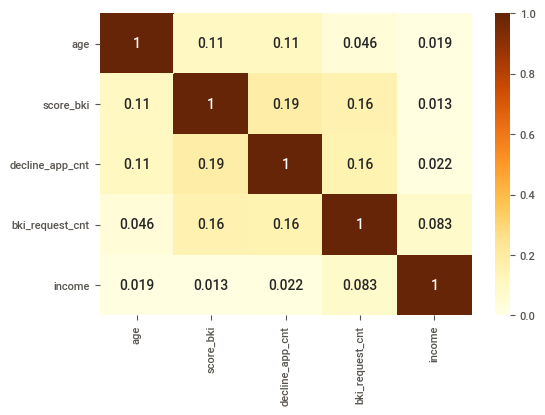

In [28]:
eda.get_correlations()

#### Выводы о пригодности признаков для модели на основе корреляционной матрицы
Признаки между собой малозваисимые, а значит все признаки подходят для модели.

### Просматриваем важность числовых признаков по отношению к целевой переменной

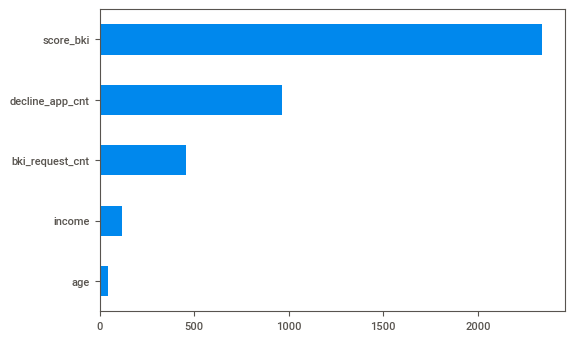

In [29]:
eda.get_fields_priority()

#### Выводы о важности числовых признаков по отношению целевой переменной
Самым важным числовм признаком является рейтинг в систме БКИ (признак score_bki).

### Составляем боксплоты для числовых столбцов для дефолтных и не дефолтных клиентов

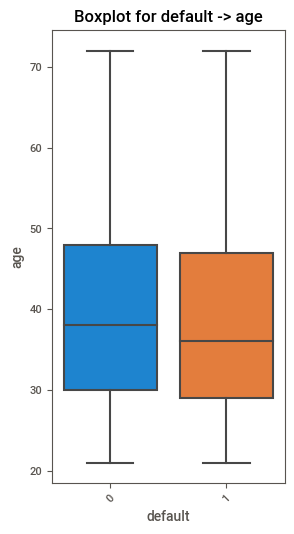

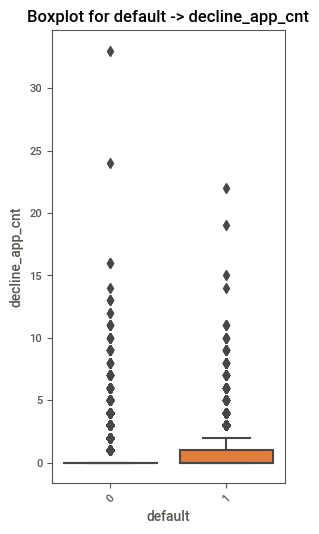

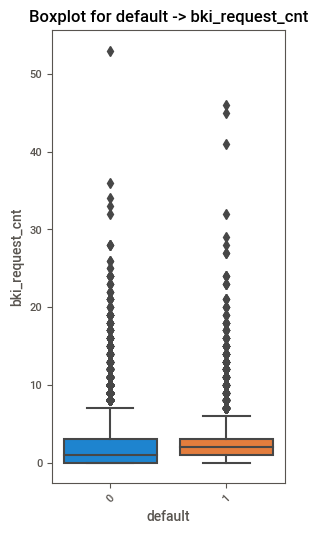

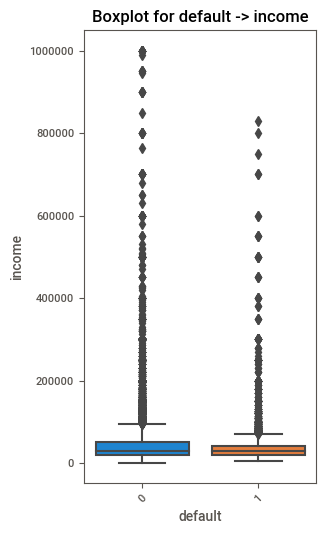

In [30]:
# составляем боксплоты для числовых столбцов для дефолтных и не дефолтных клиентов
eda.make_boxplots_default()

#### Выводы о числовых признаках у дефолтных и не дефолтных клиентов

* Медиана возраста дефолтных клиентов ниже чем у недефолтных, что говорит о более высокой вероятности дефолта у более молодых людей из-за более рисковости последних
* У недефолтных клиентов практически отсутствует отказы в крелитах по другим заявкам, а у дефолтных их довольно немало. Возможно это говорит о том что если одна кредитная институция не доверила свои деньги клиенту, то и другие будут более настороженно смотреть на клиента.
* Медиана запросов в систему БКИ у дефолтных клиентов выше чем у не дефолтных. Возможно это связанно с тем, что кредитная институция меньше запрашивает данных на по их мнению надёжных клиентов.
* Медиана доходов недефолтных клиентов выше чем у дефолтных, что говорит о возможной финансовой безграмотности дефолтных клиентов.

### Процент клиентов без отказов среди дефолтных клиентов

In [31]:
eda.get_default_customers_percent('decline_app_cnt', 0)

71.54289372599231

### Процент клиентов без запросов в БКИ среди дефолтных клиентов

In [32]:
eda.get_default_customers_percent('bki_request_cnt', 1)

23.164746052069994

#### <a href='#0'>К Оглавлению

<a id='4'></a> 
# 4. Обработка и анализ категориальных признаков

Осмотрим категориальные данные и поищем наиболее полезные для модели. Полезность будет определяться наибольшим вляиянием изменения признака на изменение целевой переменной

#### Трансформируем значения признака education в отдельные признаки с бинарными значениями

In [33]:
eda.get_column_dummies('education')

#### Осмотр бинарных признаков

In [34]:
eda.view_bin_columns()

F    41562
M    32237
Name: sex, dtype: int64 


N    49832
Y    23967
Name: car, dtype: int64 


N    59791
Y    14008
Name: car_type, dtype: int64 


0    61630
1    12169
Name: good_work, dtype: int64 


N    62733
Y    11066
Name: foreign_passport, dtype: int64 




#### Перекодируем их в числовые значения

In [35]:
eda.encode_bin_columns()

sex {0: 'F', 1: 'M'}
car {0: 'N', 1: 'Y'}
car_type {0: 'N', 1: 'Y'}
good_work {0: 0, 1: 1}
foreign_passport {0: 'N', 1: 'Y'}


#### Осмотрим другие категориальные признаки кроме признака "образование" (education)

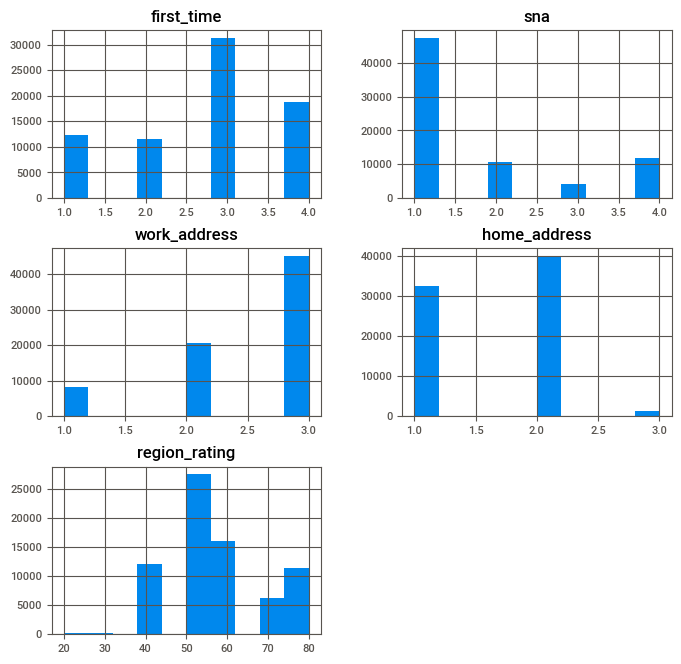

In [36]:
eda.view_cat_columns()

#### Выводы о других категориальных признаках на основе приведённых графиков
Основной вывод - данные распределены не как нормальное распределение

#### Посмотрим на значимость категориальных признаков

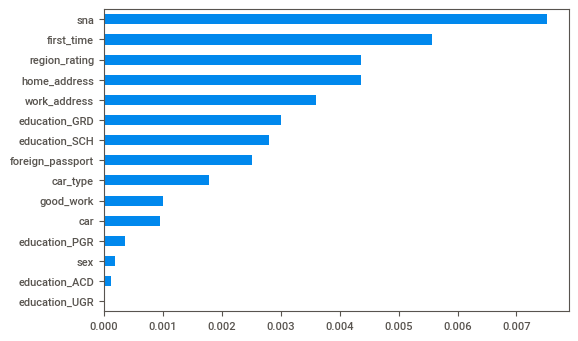

In [37]:
eda.view_cat_columns_priority()

#### Посмотрим на корреляцию между категориальными признаками

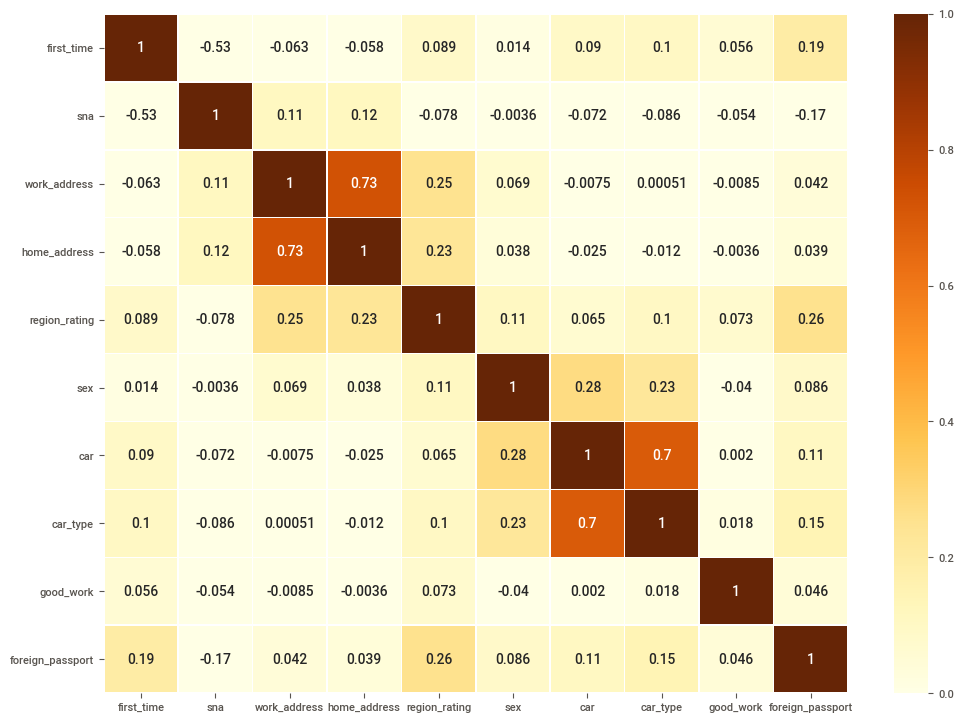

In [38]:
eda.view_cat_cols_corr()

#### Выводы о корреляциях между категориальными признаками
Наибольшая корреляция между категориальными признаками _work_address_ - _home_address_ и _car_ - _car_type_.<br>
Удалим признаки с высокой корреляцией и минимальной значимостью.<br>
<br>
Признаки "на выход": _work_address_, _first_time_ и _car_.


#### Посмотрим какие признаки меняются вместе с score_bki

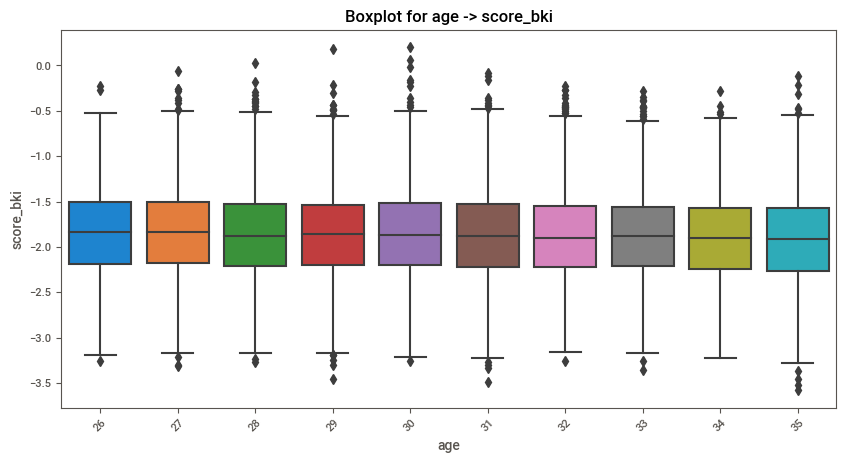

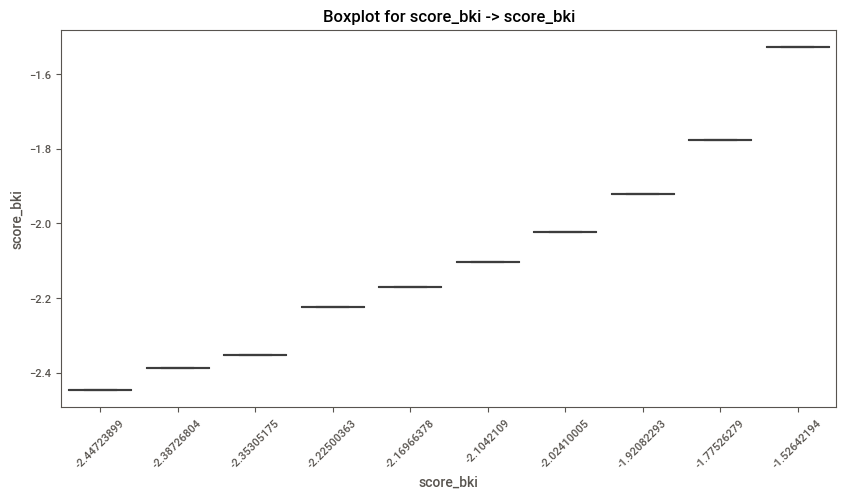

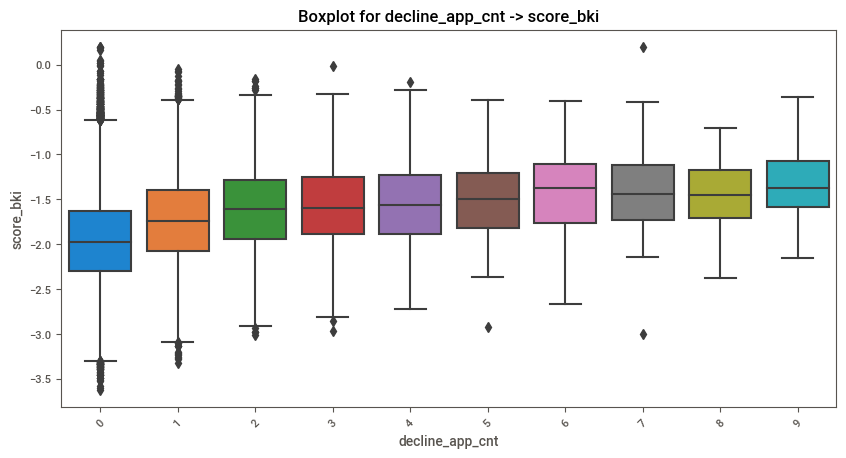

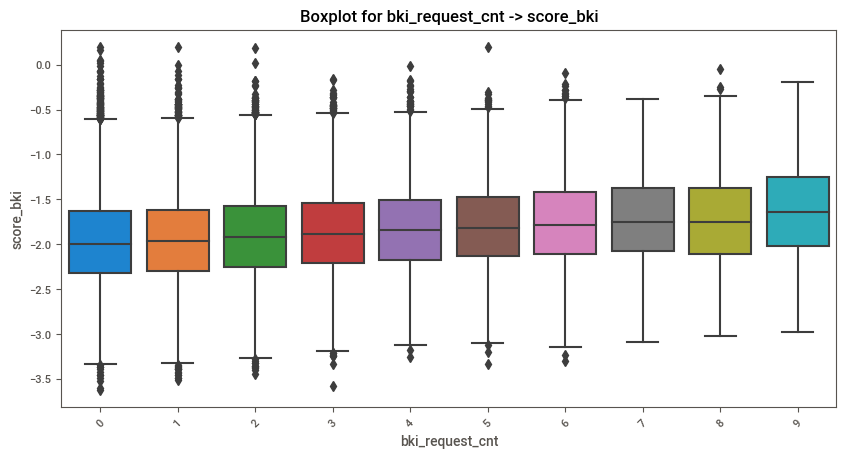

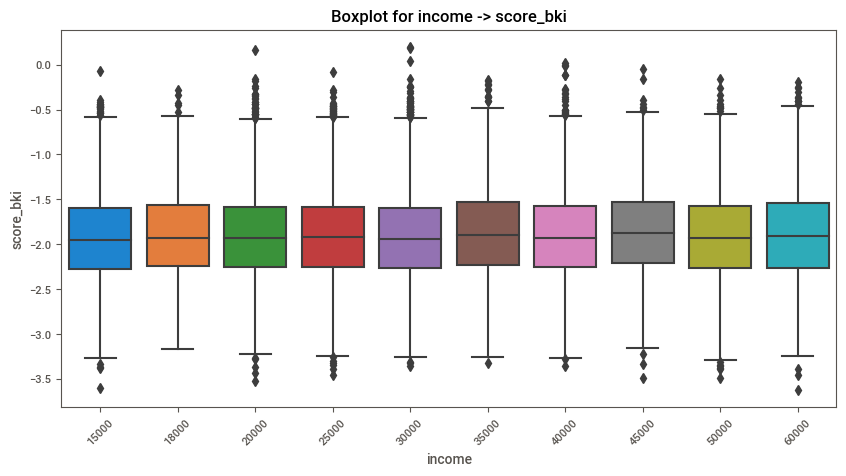

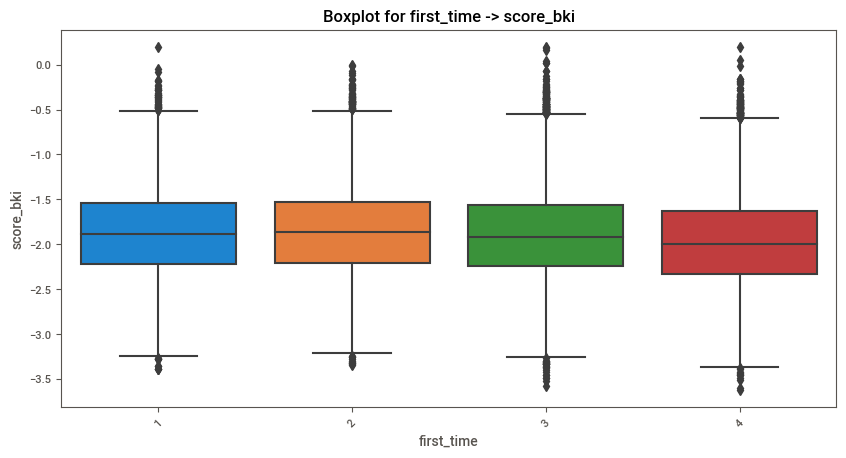

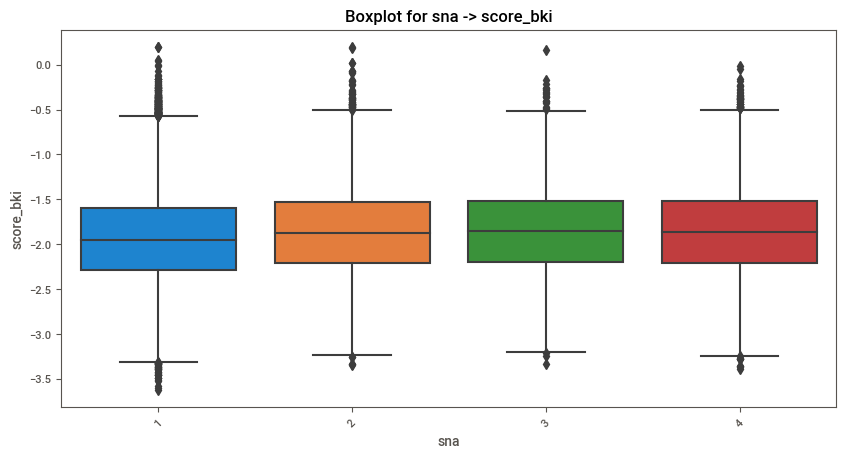

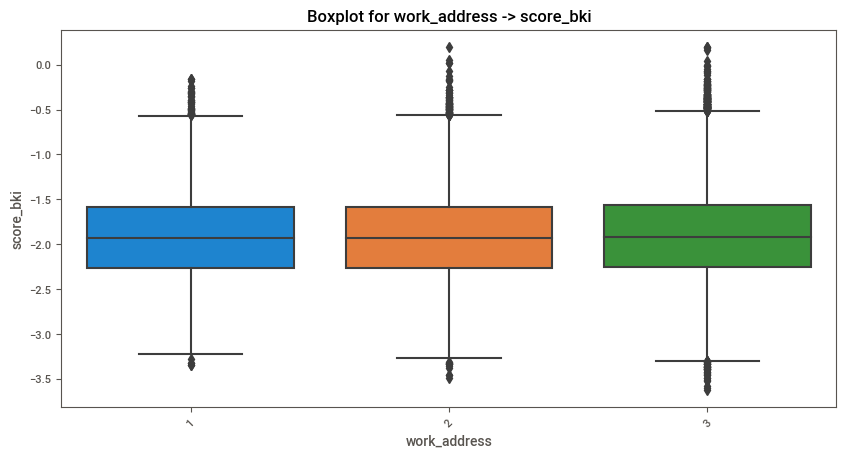

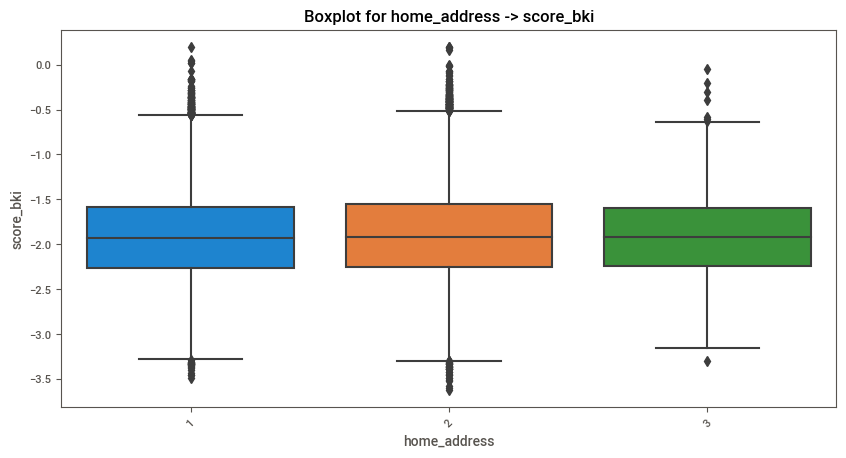

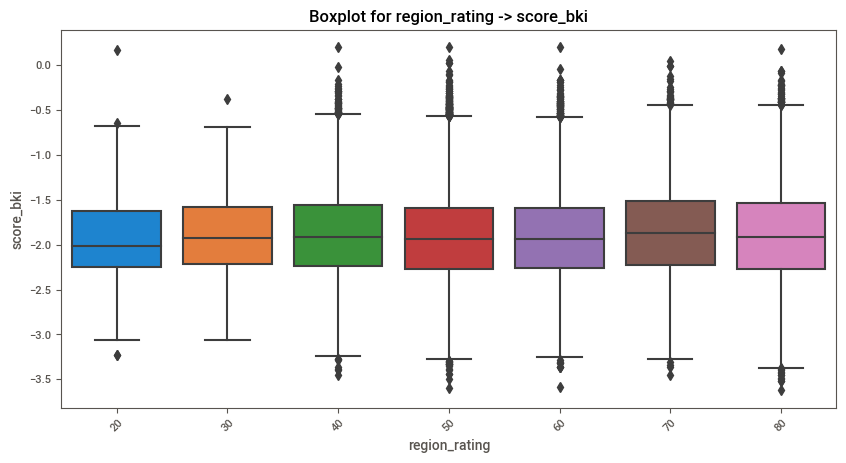

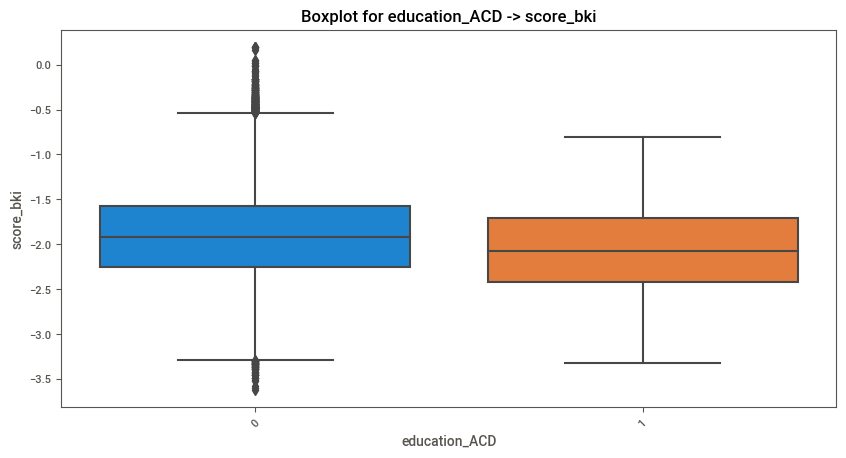

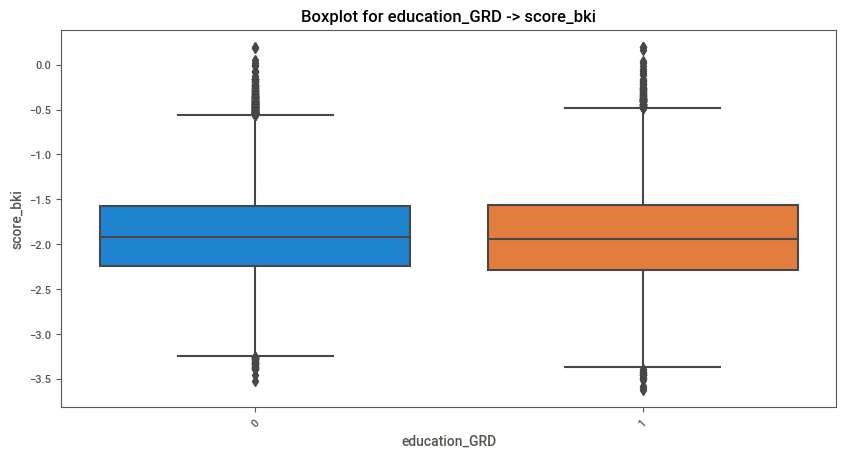

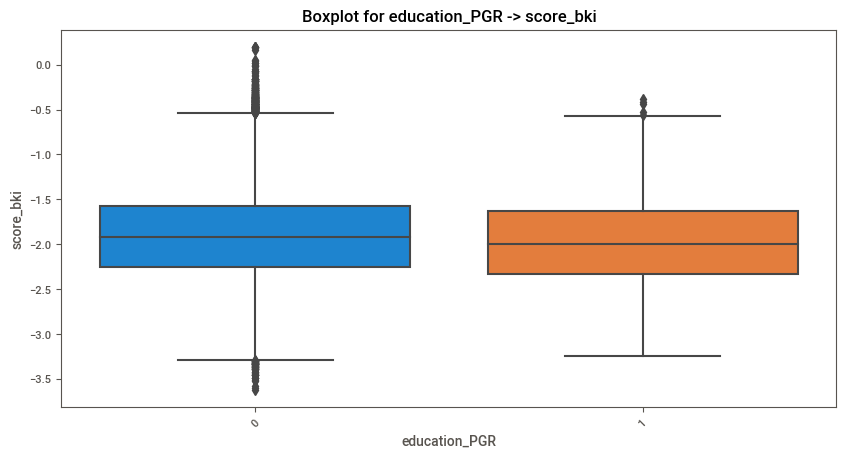

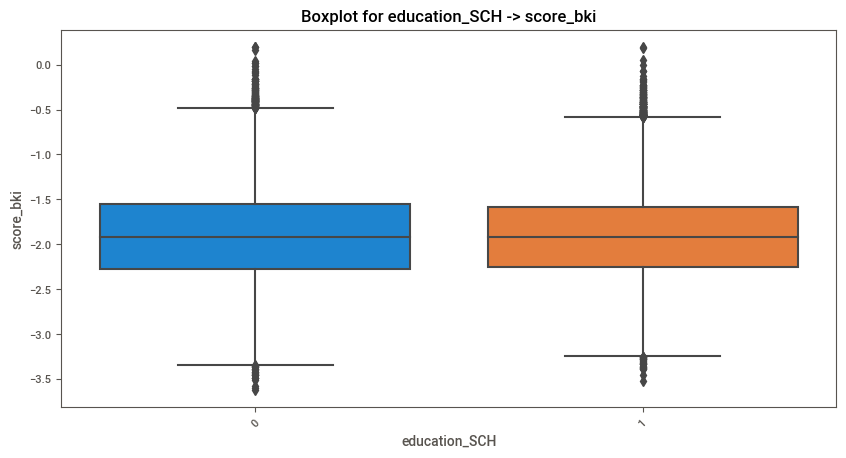

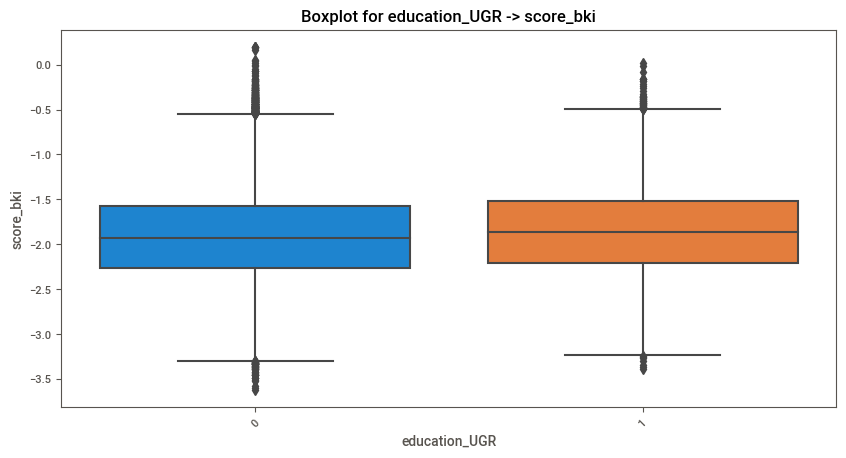

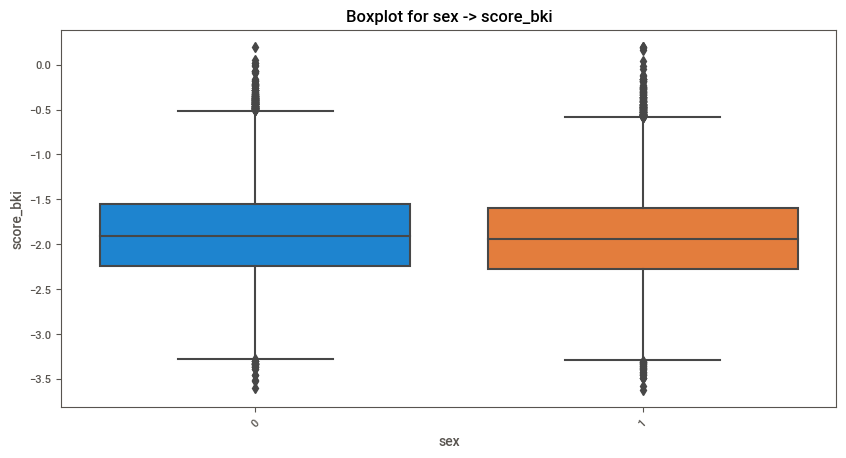

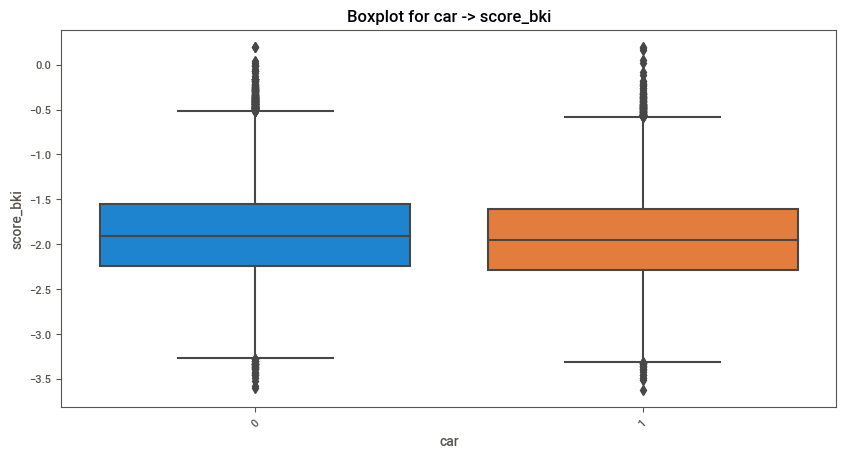

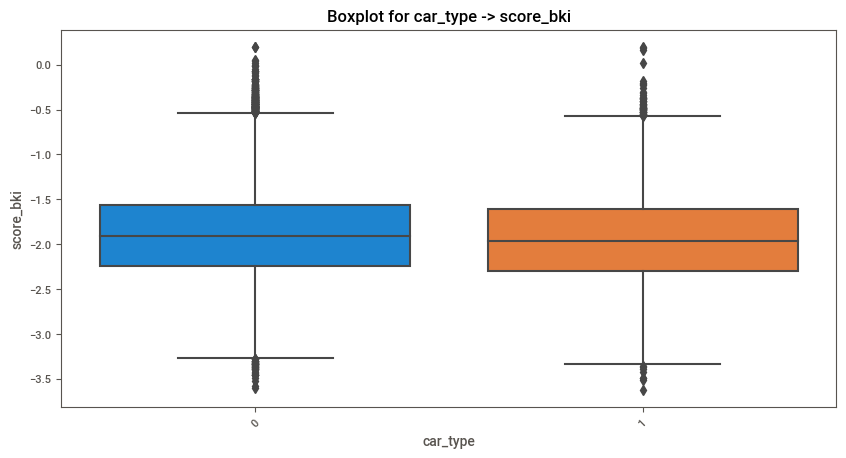

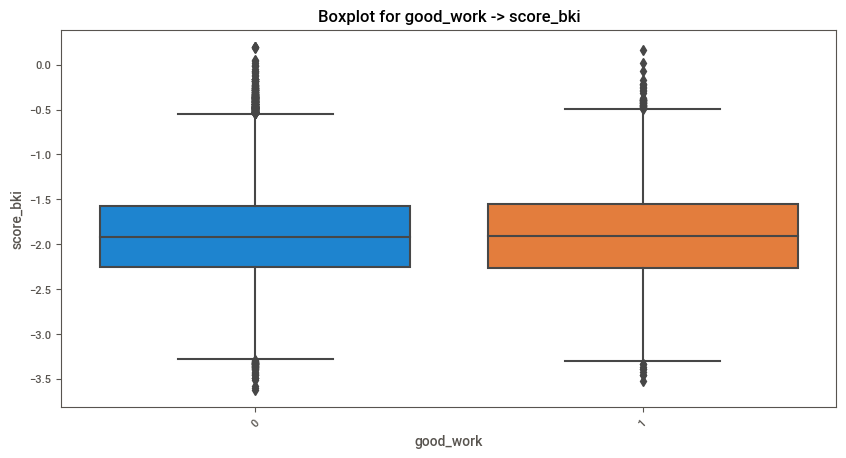

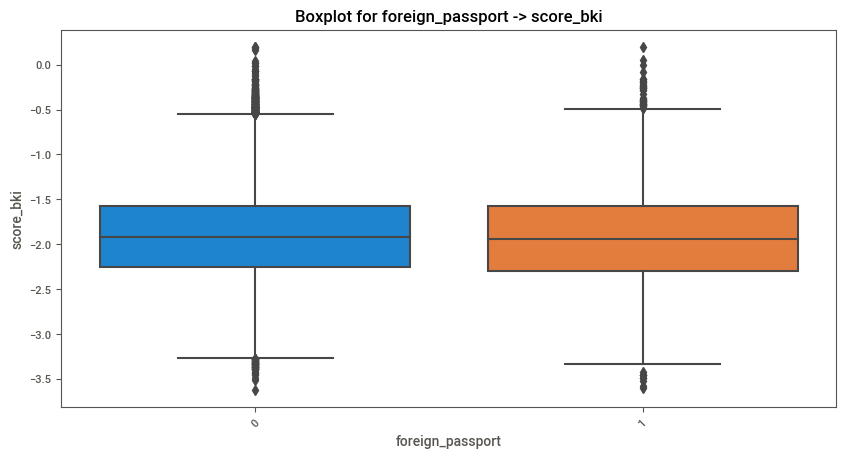

In [39]:
eda.view_cols_change_with_score_bki()    

#### Выводы о признаках меняющихся вместе с признаком score_bki
Наиболее заметно меняются признаки вместе с score_bki:
* decline_app_cnt
* bki_request_cnt
* education_ACD
* car_type

#### <a href='#0'>К Оглавлению

<a id='5'></a> 
# 5. Деление данных на обучающую и тестовую части

Logarithm Age, decline_app_cnt, income and bki_request_cnt columns
Add or not to add polynomial features
Normalize data
Numeric data after normalization
Drop unneccessary columns: work_address, first_time, car
Data split completed


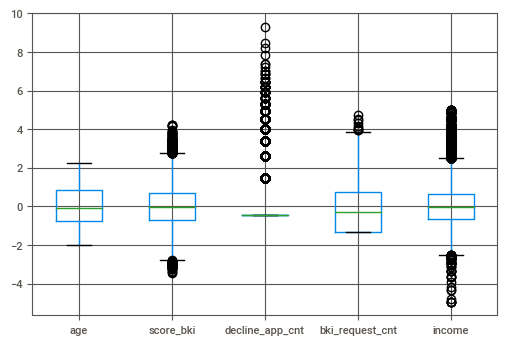

In [40]:
prepared_data = eda.get_dataframe()
num_cols = eda.get_numeric_columns()

modeler = Modeler(prepared_data, num_cols, drop_columns=[
                  'work_address', 'first_time', 'car'], verbose_mode=True)

modeler.prepare_data()
modeler.split_data()

#### <a href='#0'>К Оглавлению

<a id='6'></a>
# 6. Моделирование
<a id='61'></a>
### 6.1 Первая модель

              precision    recall  f1-score   support

           0       0.88      1.00      0.93     12933
           1       0.40      0.02      0.04      1827

    accuracy                           0.88     14760
   macro avg       0.64      0.51      0.49     14760
weighted avg       0.82      0.88      0.82     14760

[train] F1-score = 0.05 +/- 0.00
[valid] F1-score = 0.05 +/- 0.01


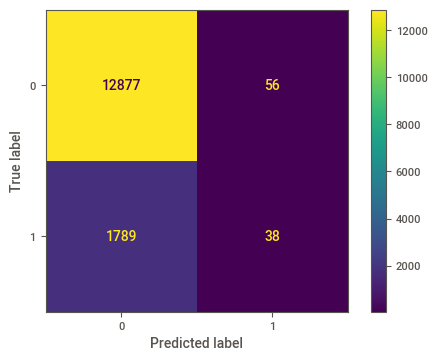

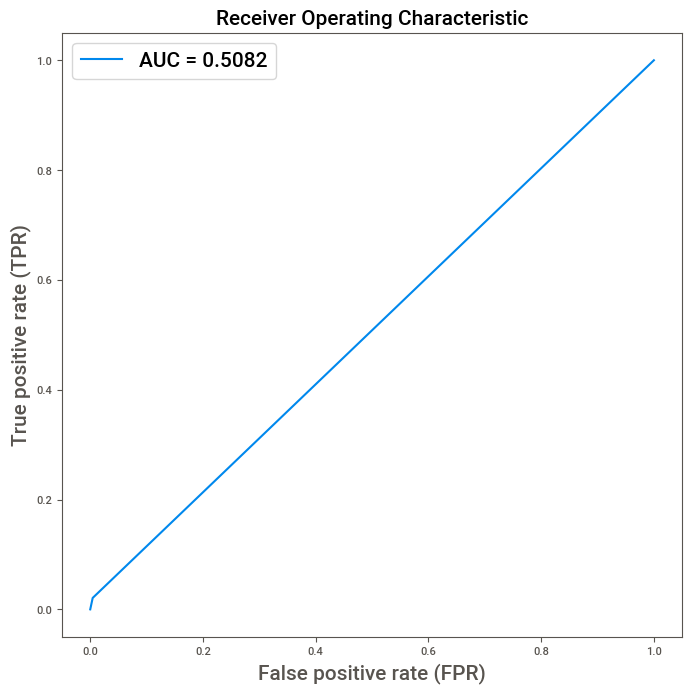

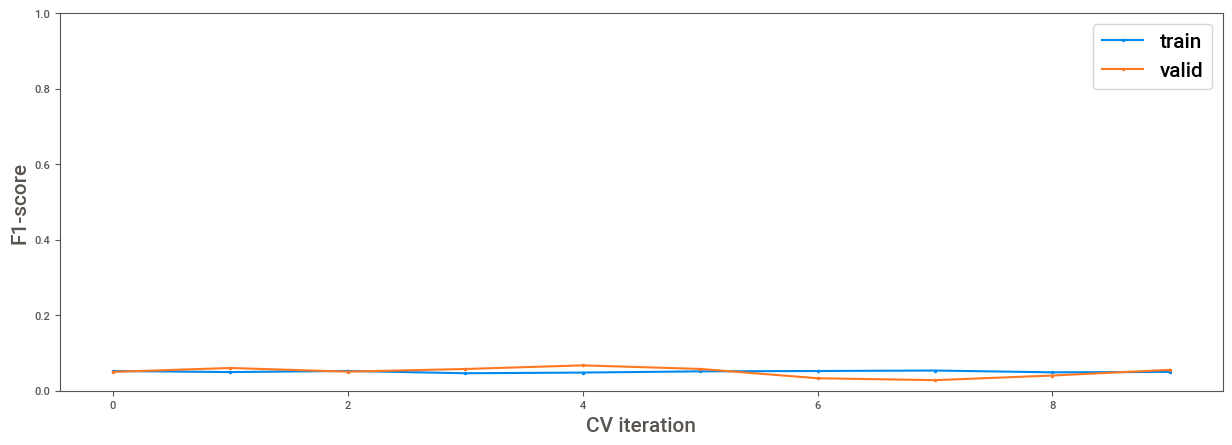

In [41]:
modeler.make_model()

#### Выводы по полученным результатам моделирования

Модель получилась слабой, поэтому попробуем включить добавление полиноминальных признаков

#### <a href='#0'>К Оглавлению

<a id='62'></a>
### 6.2 Улучшение модели
Добавим включение в модель полиноминальных признаков

Logarithm Age, decline_app_cnt, income and bki_request_cnt columns
Add or not to add polynomial features
Normalize data
Numeric data after normalization
Drop unneccessary columns: work_address, first_time, car
Data split completed
              precision    recall  f1-score   support

           0       0.88      1.00      0.93     12933
           1       0.42      0.02      0.03      1827

    accuracy                           0.88     14760
   macro avg       0.65      0.51      0.48     14760
weighted avg       0.82      0.88      0.82     14760

[train] F1-score = 0.04 +/- 0.00
[valid] F1-score = 0.04 +/- 0.01


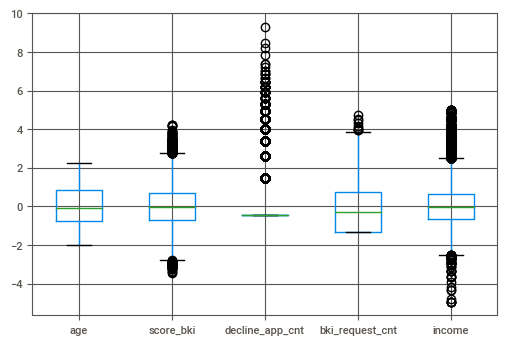

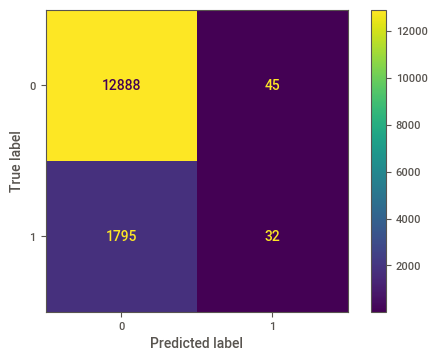

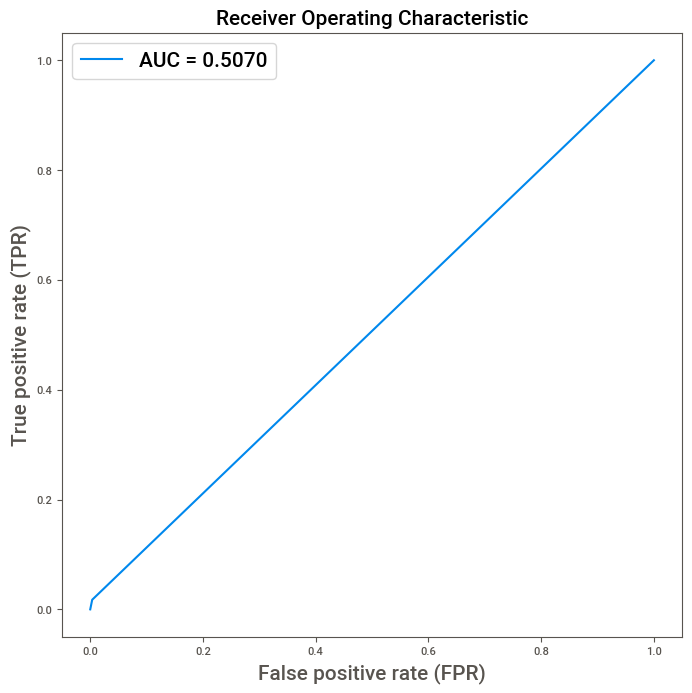

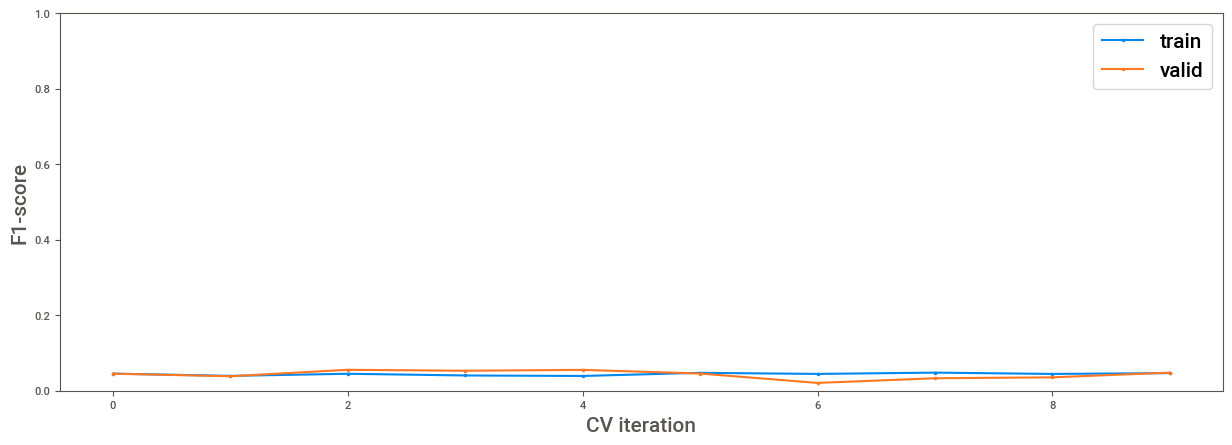

In [42]:
modeler = Modeler(prepared_data, num_cols, with_poly_ft=True, drop_columns=[
                  'work_address', 'first_time', 'car'], verbose_mode=True)

modeler.prepare_data()
modeler.split_data()
modeler.make_model()

Результат получился ещё хуже....

#### <a href='#0'>К Оглавлению

<a id='63'></a>
### 6.3 Пробуем undersampling и oversampling

              precision    recall  f1-score   support

           0       0.72      0.71      0.71      6442
           1       0.71      0.72      0.72      6444

    accuracy                           0.71     12886
   macro avg       0.71      0.71      0.71     12886
weighted avg       0.71      0.71      0.71     12886



NameError: name 'logreg_us' is not defined

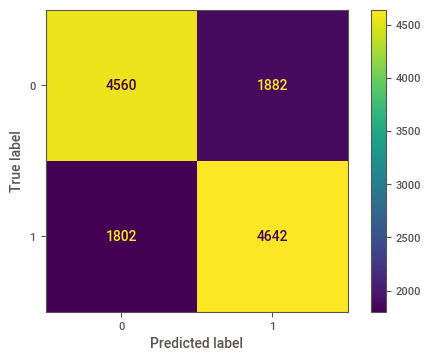

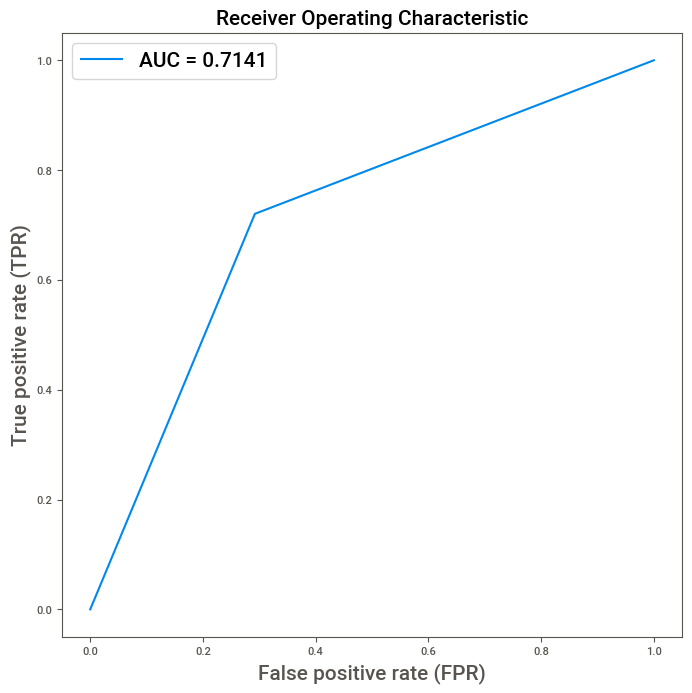

In [43]:
modeler = Modeler(prepared_data, num_cols, drop_columns=[
                  'work_address', 'first_time', 'car'])

modeler.prepare_data()
modeler.make_model_os_us()

Теперь результат намного лучше!

<a id='64'></a>
### 6.4 Кросс-валидация модели

Судя по графикам сгенерированным после моделирования, модель обучалась нормально без недообучения и переобучения

#### <a href='#0'>К Оглавлению

<a id='7'></a>
# 7. Подбор гиперпараметров

<a id='71'></a>
### 7.1 Поиск параметров

In [ ]:
modeler = Modeler(prepared_data, num_cols, drop_columns=[
                  'work_address', 'first_time', 'car'])

modeler.prepare_data()
modeler.split_data()
modeler.print_hyperparams(iter=1000)

#### <a href='#0'>К Оглавлению

<a id='72'></a>
### 7.2 Моделирование с рекомендованными параметрами
Зададим отличные от значений по умолчанию параметры. Параметры конструктора класса LogisticRegression по умолчанию можно найти <a href='https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html'>тут</a>

Изменять будем следующие параметры:
* class_weight -> 'balanced'
* max_iter -> 1000
* penalty -> 'l1'
* random_state -> None
* tol -> 0.001


#### <a href='#0'>К Оглавлению

#### С парамерами по умолчанию

In [ ]:
modeler = Modeler(prepared_data, num_cols, drop_columns=[
                  'work_address', 'first_time', 'car'], random_state=None,
                  class_weight='balanced', max_iter=1000, penalty='l1', tol=0.001)

modeler.prepare_data()
modeler.split_data()
modeler.make_model()

#### С oversampling и undersampling

In [ ]:
modeler = Modeler(prepared_data, num_cols, drop_columns=[
                  'work_address', 'first_time', 'car'], random_state=None,
                  class_weight='balanced', max_iter=1000, penalty='l1', tol=0.001)

modeler.prepare_data()
modeler.make_model_os_us()

### Выводы о моделировании с рекомендованными параметрами

Судя по полученным метрикам и графику ROC AUC, рекомендованные параметры улучшили точность предсказаний

#### <a href='#0'>К Оглавлению

<a id='8'></a>
# 8. Генерирование файла для kaggle

In [ ]:
# предобработка тестовых данных
test = pd.read_csv('test.csv')
eda_test = EDA(test)

eda_test.get_column_dummies('education')

eda_test.encode_bin_columns()
# просмотр тестовых данных
test_data = eda_test.get_dataframe().info()

In [47]:
# предсказываем на тестовых данных
predict_submission = modeler.get_logreg().predict(test_data)

sample_submission = pd.read_csv('sample_submission.csv')
sample_submission['default'] = predict_submission
sample_submission.to_csv('submission.csv', index=False)
sample_submission.head(10)

,client_id,default
0,74835,1
1,17527,1
2,75683,1
3,26883,1
4,28862,1
5,99881,1
6,26630,1
7,79934,1
8,16605,1
9,105449,1
